In [1]:
import pandas as pd
import numpy as np
import joblib
import os

# Loại bỏ sklearn.ensemble vì LSTM không nằm ở đây
# import các thư viện cần cho LSTM từ keras/tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


2025-05-27 18:28:34.630455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748370514.922220      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748370515.007639      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'units': [32, 64, 128],               # số neurons LSTM
    'dropout': [0.2, 0.3, 0.5],          # dropout rate
    'batch_size': [16, 32, 64],           # batch size khi train
    'epochs': [10, 20, 50],               # số epochs
    'learning_rate': [0.001, 0.0005, 0.0001],  # tốc độ học
}


In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

def build_lstm_model(input_shape, num_classes, units=64, dropout=0.3):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_phase(phase_path, n_iter=10, random_state=42, sample=False, epochs=30, batch_size=32):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Reshape dữ liệu cho LSTM: (samples, timesteps=1, features)
        X_train_lstm = np.expand_dims(X_train_scaled.values, axis=1)
        X_val_lstm = np.expand_dims(X_val_scaled.values, axis=1)

        # One-hot encode label
        classes = np.unique(np.concatenate((y_train, y_val)))
        num_classes = len(classes)
        y_train_cat = to_categorical(np.searchsorted(classes, y_train), num_classes)
        y_val_cat = to_categorical(np.searchsorted(classes, y_val), num_classes)

        # Xây dựng mô hình LSTM (bạn có thể thay đổi params hoặc thêm vòng loop tuning riêng)
        model = build_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), num_classes=num_classes)

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train_lstm, y_train_cat,
            validation_data=(X_val_lstm, y_val_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=2
        )

        # Dự đoán
        y_proba = model.predict(X_val_lstm)
        y_pred = np.argmax(y_proba, axis=1)
        y_true_idx = np.searchsorted(classes, y_val)

        acc = accuracy_score(y_true_idx, y_pred)
        f1 = f1_score(y_true_idx, y_pred, average='macro')

        y_val_bin = label_binarize(y_true_idx, classes=range(num_classes))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_true_idx, y_pred))

        cm = confusion_matrix(y_true_idx, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Không có feature_importances_ với LSTM, bỏ phần đó

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========



2025-05-27 18:28:52.948766: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
340/340 - 5s - 15ms/step - accuracy: 0.6437 - loss: 1.0528 - val_accuracy: 0.6648 - val_loss: 0.8595
Epoch 2/30
340/340 - 1s - 4ms/step - accuracy: 0.6731 - loss: 0.8441 - val_accuracy: 0.6740 - val_loss: 0.8153
Epoch 3/30
340/340 - 1s - 4ms/step - accuracy: 0.6810 - loss: 0.8127 - val_accuracy: 0.6906 - val_loss: 0.7938
Epoch 4/30
340/340 - 1s - 4ms/step - accuracy: 0.6833 - loss: 0.7995 - val_accuracy: 0.6947 - val_loss: 0.7880
Epoch 5/30
340/340 - 1s - 4ms/step - accuracy: 0.6868 - loss: 0.7892 - val_accuracy: 0.6921 - val_loss: 0.7861
Epoch 6/30
340/340 - 1s - 4ms/step - accuracy: 0.6875 - loss: 0.7820 - val_accuracy: 0.6884 - val_loss: 0.7807
Epoch 7/30
340/340 - 1s - 4ms/step - accuracy: 0.6909 - loss: 0.7744 - val_accuracy: 0.6972 - val_loss: 0.7709
Epoch 8/30
340/340 - 2s - 4ms/step - accuracy: 0.6914 - loss: 0.7716 - val_accuracy: 0.6972 - val_loss: 0.7679
Epoch 9/30
340/340 - 1s - 4ms/step - accuracy: 0.6901 - loss: 0.7713 - val_accuracy: 0.6965 - val_loss: 0.7640


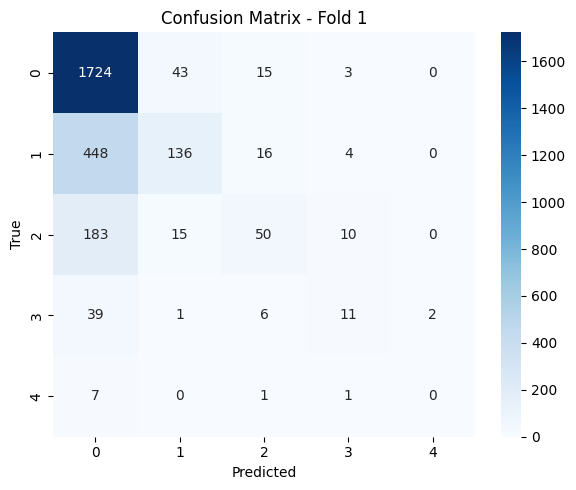

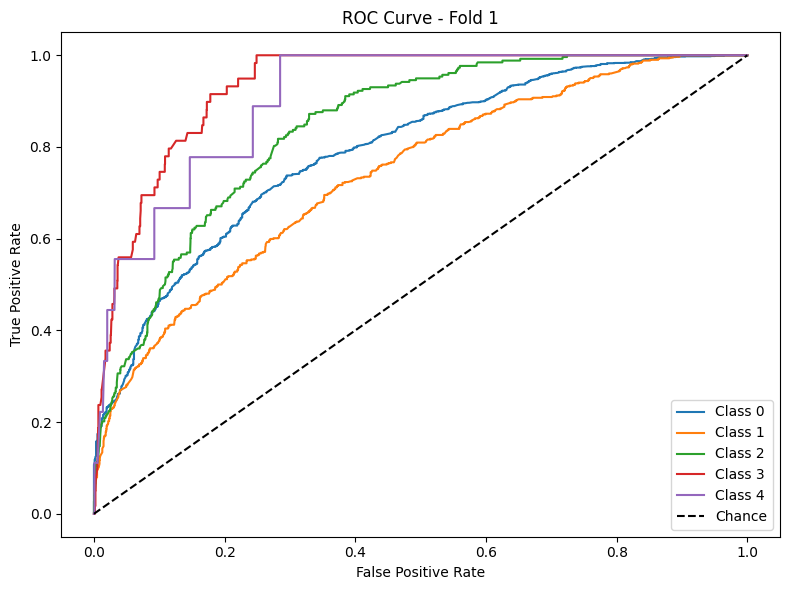

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 15ms/step - accuracy: 0.6367 - loss: 1.0696 - val_accuracy: 0.6684 - val_loss: 0.8750
Epoch 2/30
340/340 - 1s - 4ms/step - accuracy: 0.6721 - loss: 0.8464 - val_accuracy: 0.6868 - val_loss: 0.8201
Epoch 3/30
340/340 - 1s - 4ms/step - accuracy: 0.6800 - loss: 0.8188 - val_accuracy: 0.6887 - val_loss: 0.8064
Epoch 4/30
340/340 - 1s - 4ms/step - accuracy: 0.6858 - loss: 0.7979 - val_accuracy: 0.6875 - val_loss: 0.7949
Epoch 5/30
340/340 - 1s - 4ms/step - accuracy: 0.6906 - loss: 0.7865 - val_accuracy: 0.6875 - val_loss: 0.7922
Epoch 6/30
340/340 - 1s - 4ms/step - accuracy: 0.6891 - loss: 0.7813 - val_accuracy: 0.6901 - val_loss: 0.7847
Epoch 7/30
340/340 - 1s - 4ms/step - accuracy: 0.6895 - loss: 0.7774 - val_accuracy: 0.6887 - val_loss: 0.7853
Epoch 8/30
340/340 - 1s - 4ms/step - accuracy: 0.6939 - loss: 0.7701 - val_accuracy: 0.6901 - val_loss: 0.7772
Epoch 9/30
340/340 - 1s - 4ms/step - accuracy: 0.6935 - loss: 0.7624 - val_accuracy: 0.6938 - val_loss: 0.7695
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


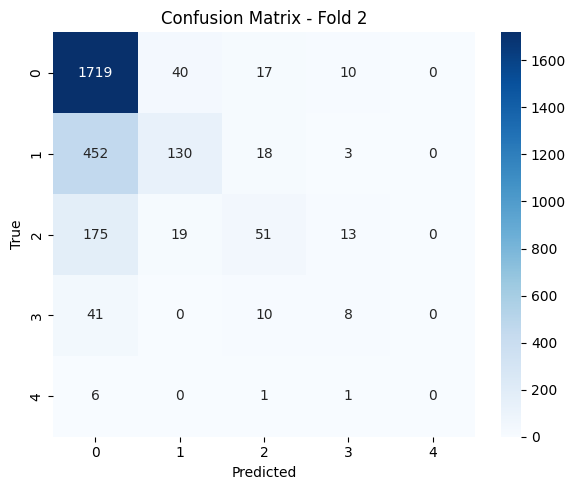

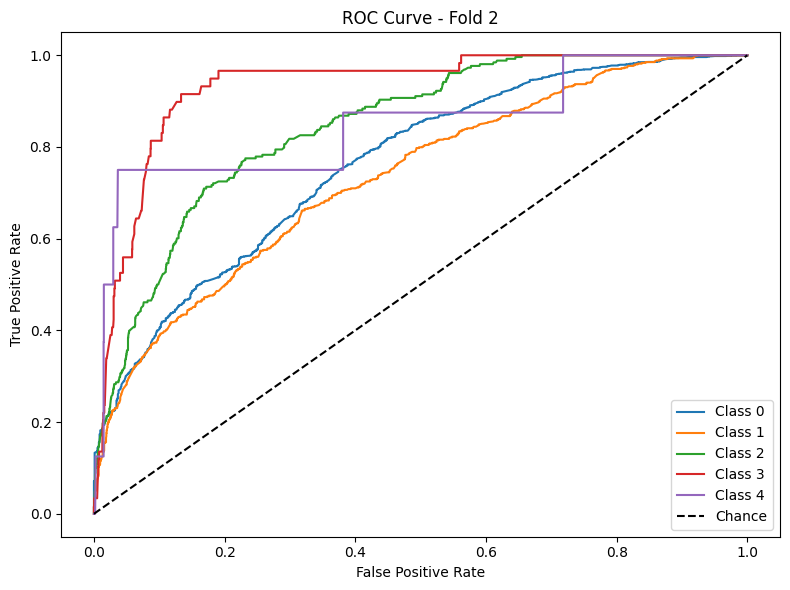

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 14ms/step - accuracy: 0.6368 - loss: 1.0769 - val_accuracy: 0.6651 - val_loss: 0.8775
Epoch 2/30
340/340 - 1s - 4ms/step - accuracy: 0.6719 - loss: 0.8535 - val_accuracy: 0.6817 - val_loss: 0.8199
Epoch 3/30
340/340 - 1s - 4ms/step - accuracy: 0.6811 - loss: 0.8194 - val_accuracy: 0.6872 - val_loss: 0.7979
Epoch 4/30
340/340 - 1s - 4ms/step - accuracy: 0.6842 - loss: 0.8060 - val_accuracy: 0.6864 - val_loss: 0.7882
Epoch 5/30
340/340 - 1s - 4ms/step - accuracy: 0.6879 - loss: 0.7945 - val_accuracy: 0.6879 - val_loss: 0.7768
Epoch 6/30
340/340 - 1s - 4ms/step - accuracy: 0.6865 - loss: 0.7897 - val_accuracy: 0.6905 - val_loss: 0.7726
Epoch 7/30
340/340 - 1s - 4ms/step - accuracy: 0.6876 - loss: 0.7865 - val_accuracy: 0.6945 - val_loss: 0.7636
Epoch 8/30
340/340 - 1s - 4ms/step - accuracy: 0.6915 - loss: 0.7750 - val_accuracy: 0.6931 - val_loss: 0.7626
Epoch 9/30
340/340 - 1s - 4ms/step - accuracy: 0.6925 - loss: 0.7718 - val_accuracy: 0.6993 - val_loss: 0.7556
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


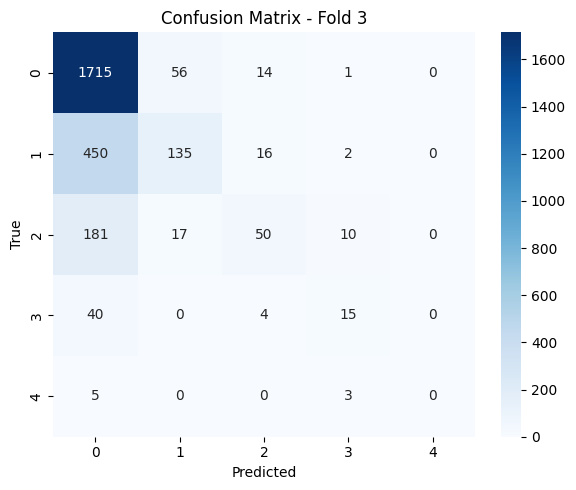

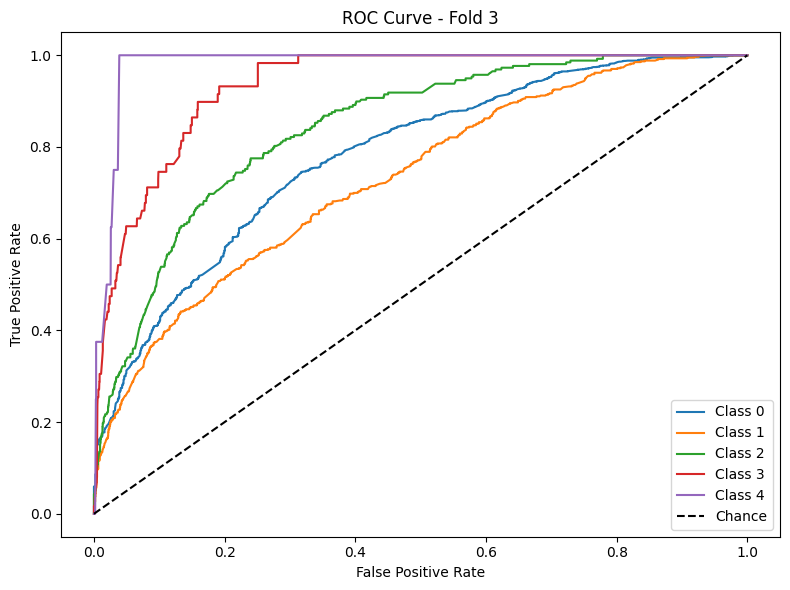

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 15ms/step - accuracy: 0.6336 - loss: 1.0685 - val_accuracy: 0.6680 - val_loss: 0.8748
Epoch 2/30
340/340 - 1s - 4ms/step - accuracy: 0.6757 - loss: 0.8492 - val_accuracy: 0.6890 - val_loss: 0.8136
Epoch 3/30
340/340 - 1s - 4ms/step - accuracy: 0.6820 - loss: 0.8147 - val_accuracy: 0.6949 - val_loss: 0.7970
Epoch 4/30
340/340 - 1s - 4ms/step - accuracy: 0.6820 - loss: 0.8050 - val_accuracy: 0.6949 - val_loss: 0.7852
Epoch 5/30
340/340 - 1s - 4ms/step - accuracy: 0.6842 - loss: 0.7954 - val_accuracy: 0.7019 - val_loss: 0.7706
Epoch 6/30
340/340 - 1s - 4ms/step - accuracy: 0.6883 - loss: 0.7884 - val_accuracy: 0.6982 - val_loss: 0.7686
Epoch 7/30
340/340 - 1s - 4ms/step - accuracy: 0.6879 - loss: 0.7835 - val_accuracy: 0.6982 - val_loss: 0.7597
Epoch 8/30
340/340 - 1s - 4ms/step - accuracy: 0.6886 - loss: 0.7727 - val_accuracy: 0.6990 - val_loss: 0.7571
Epoch 9/30
340/340 - 1s - 4ms/step - accuracy: 0.6897 - loss: 0.7691 - val_accuracy: 0.7012 - val_loss: 0.7540
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


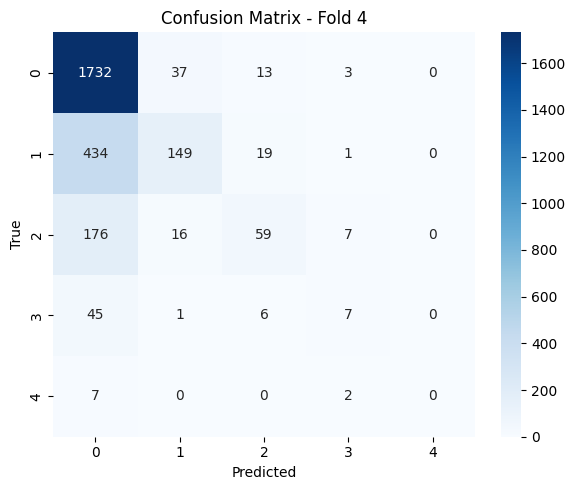

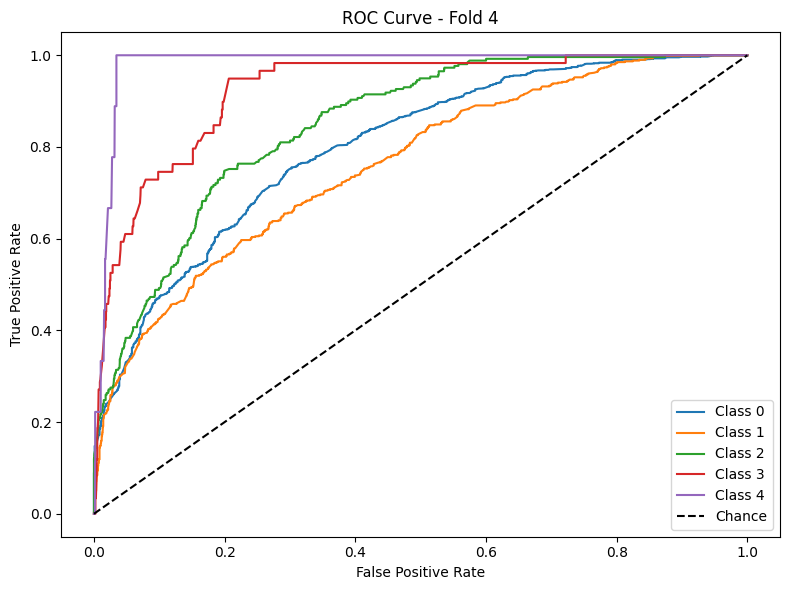

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 13ms/step - accuracy: 0.6351 - loss: 1.0579 - val_accuracy: 0.6614 - val_loss: 0.8615
Epoch 2/30
340/340 - 1s - 4ms/step - accuracy: 0.6678 - loss: 0.8506 - val_accuracy: 0.6824 - val_loss: 0.8102
Epoch 3/30
340/340 - 1s - 4ms/step - accuracy: 0.6791 - loss: 0.8166 - val_accuracy: 0.6942 - val_loss: 0.7924
Epoch 4/30
340/340 - 1s - 4ms/step - accuracy: 0.6891 - loss: 0.8001 - val_accuracy: 0.6945 - val_loss: 0.7857
Epoch 5/30
340/340 - 1s - 4ms/step - accuracy: 0.6896 - loss: 0.7907 - val_accuracy: 0.6953 - val_loss: 0.7780
Epoch 6/30
340/340 - 1s - 4ms/step - accuracy: 0.6896 - loss: 0.7827 - val_accuracy: 0.6945 - val_loss: 0.7704
Epoch 7/30
340/340 - 1s - 4ms/step - accuracy: 0.6937 - loss: 0.7748 - val_accuracy: 0.6986 - val_loss: 0.7651
Epoch 8/30
340/340 - 1s - 4ms/step - accuracy: 0.6962 - loss: 0.7664 - val_accuracy: 0.6993 - val_loss: 0.7609
Epoch 9/30
340/340 - 1s - 4ms/step - accuracy: 0.6943 - loss: 0.7670 - val_accuracy: 0.6997 - val_loss: 0.7571
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


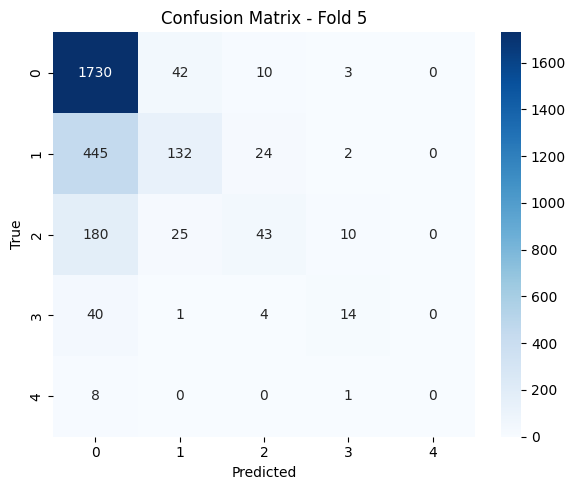

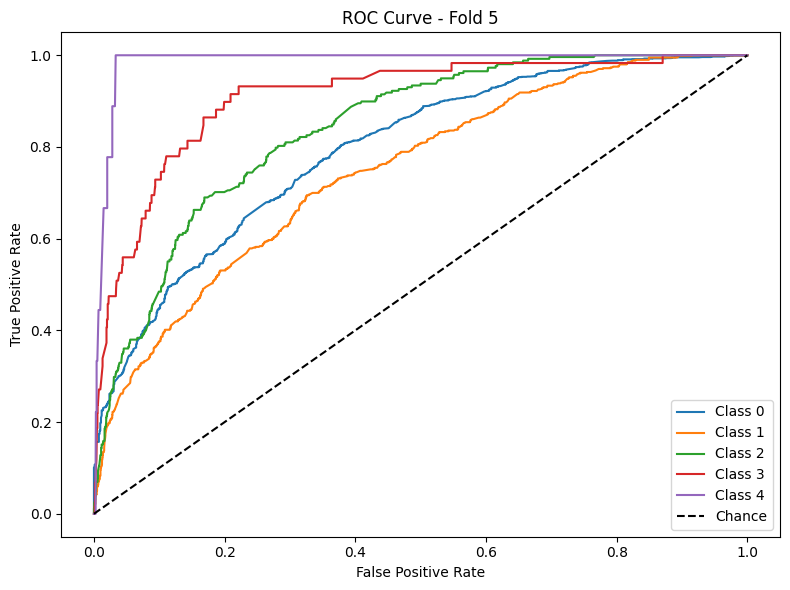


Average Accuracy: 0.7081
Average F1 Macro: 0.3409
Average AUC: 0.8478


======= Training Phase 2 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 5s - 17ms/step - accuracy: 0.6234 - loss: 1.1133 - val_accuracy: 0.6681 - val_loss: 0.9050
Epoch 2/30
283/283 - 1s - 4ms/step - accuracy: 0.6688 - loss: 0.8706 - val_accuracy: 0.6721 - val_loss: 0.8449
Epoch 3/30
283/283 - 1s - 4ms/step - accuracy: 0.6790 - loss: 0.8260 - val_accuracy: 0.6757 - val_loss: 0.8224
Epoch 4/30
283/283 - 1s - 4ms/step - accuracy: 0.6783 - loss: 0.8133 - val_accuracy: 0.6792 - val_loss: 0.8106
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6818 - loss: 0.8016 - val_accuracy: 0.6783 - val_loss: 0.8054
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6865 - loss: 0.7893 - val_accuracy: 0.6836 - val_loss: 0.7925
Epoch 7/30
283/283 - 1s - 4ms/step - accuracy: 0.6871 - loss: 0.7854 - val_accuracy: 0.6836 - val_loss: 0.7913
Epoch 8/30
283/283 - 1s - 4ms/step - accuracy: 0.6872 - loss: 0.7806 - val_accuracy: 0.6796 - val_loss: 0.7856
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.6888 - loss: 0.7737 - val_accuracy: 0.6827 - val_loss: 0.7786
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


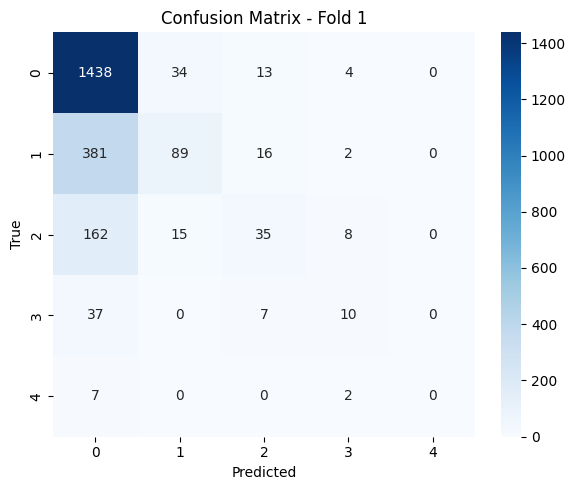

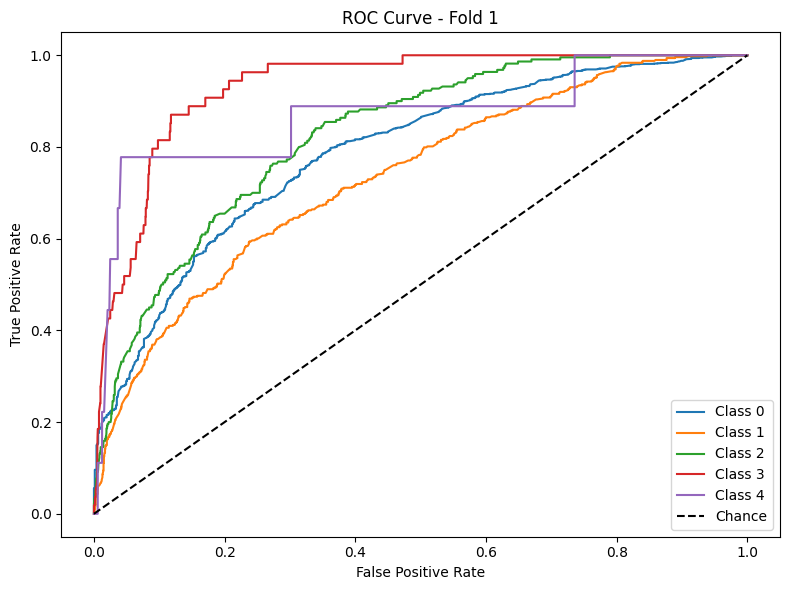

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 15ms/step - accuracy: 0.6276 - loss: 1.1167 - val_accuracy: 0.6650 - val_loss: 0.8956
Epoch 2/30
283/283 - 1s - 4ms/step - accuracy: 0.6670 - loss: 0.8696 - val_accuracy: 0.6823 - val_loss: 0.8269
Epoch 3/30
283/283 - 1s - 4ms/step - accuracy: 0.6758 - loss: 0.8323 - val_accuracy: 0.6845 - val_loss: 0.8094
Epoch 4/30
283/283 - 1s - 4ms/step - accuracy: 0.6812 - loss: 0.8104 - val_accuracy: 0.6845 - val_loss: 0.7966
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6829 - loss: 0.7995 - val_accuracy: 0.6730 - val_loss: 0.7893
Epoch 6/30
283/283 - 1s - 3ms/step - accuracy: 0.6806 - loss: 0.7939 - val_accuracy: 0.6823 - val_loss: 0.7864
Epoch 7/30
283/283 - 1s - 4ms/step - accuracy: 0.6844 - loss: 0.7830 - val_accuracy: 0.6832 - val_loss: 0.7775
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6856 - loss: 0.7820 - val_accuracy: 0.6925 - val_loss: 0.7742
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.6882 - loss: 0.7753 - val_accuracy: 0.6881 - val_loss: 0.7705
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


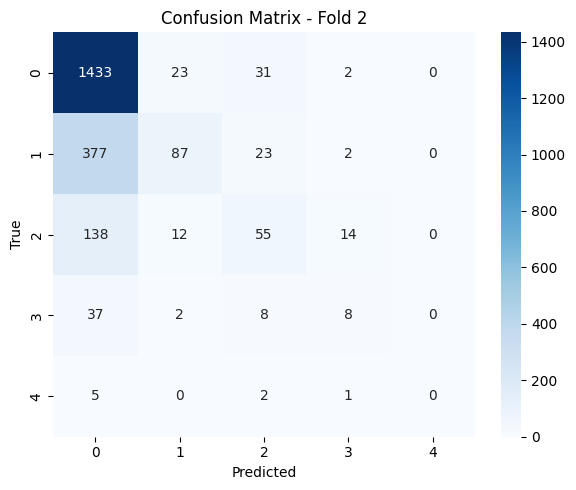

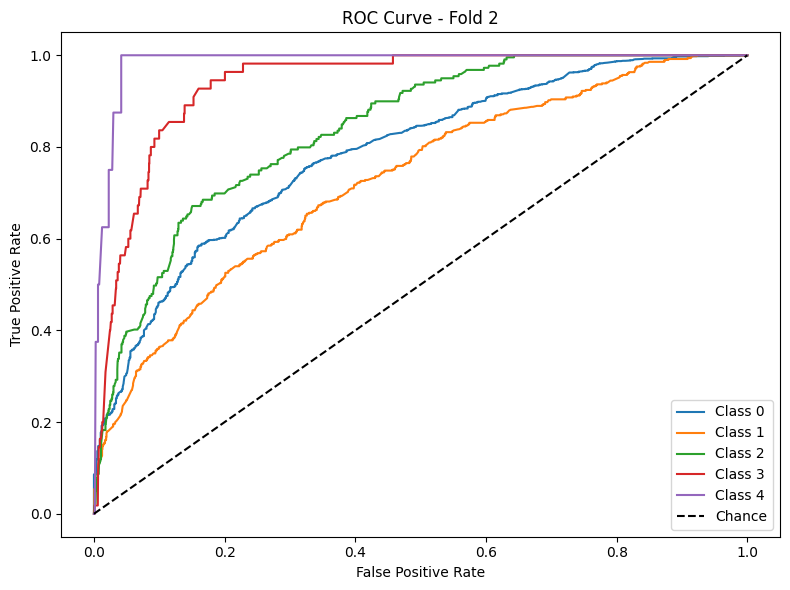

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 15ms/step - accuracy: 0.6104 - loss: 1.1286 - val_accuracy: 0.6627 - val_loss: 0.9156
Epoch 2/30
283/283 - 1s - 4ms/step - accuracy: 0.6677 - loss: 0.8696 - val_accuracy: 0.6768 - val_loss: 0.8454
Epoch 3/30
283/283 - 1s - 4ms/step - accuracy: 0.6779 - loss: 0.8271 - val_accuracy: 0.6804 - val_loss: 0.8195
Epoch 4/30
283/283 - 1s - 4ms/step - accuracy: 0.6833 - loss: 0.8083 - val_accuracy: 0.6822 - val_loss: 0.8120
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6858 - loss: 0.8003 - val_accuracy: 0.6791 - val_loss: 0.8030
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6855 - loss: 0.7894 - val_accuracy: 0.6826 - val_loss: 0.7985
Epoch 7/30
283/283 - 1s - 4ms/step - accuracy: 0.6877 - loss: 0.7839 - val_accuracy: 0.6830 - val_loss: 0.7921
Epoch 8/30
283/283 - 1s - 4ms/step - accuracy: 0.6920 - loss: 0.7787 - val_accuracy: 0.6813 - val_loss: 0.7924
Epoch 9/30
283/283 - 1s - 4ms/step - accuracy: 0.6902 - loss: 0.7703 - val_accuracy: 0.6804 - val_loss: 0.7888
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


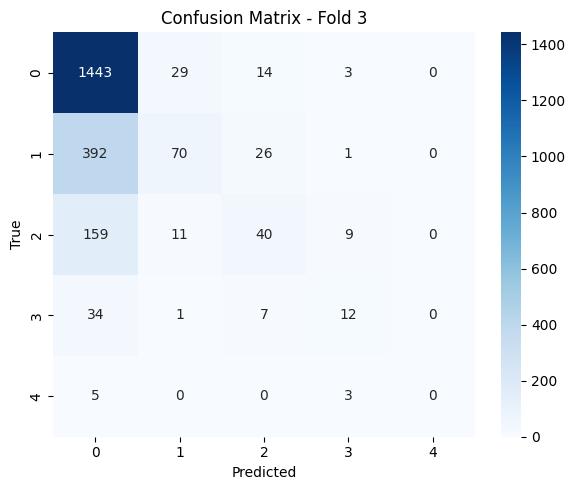

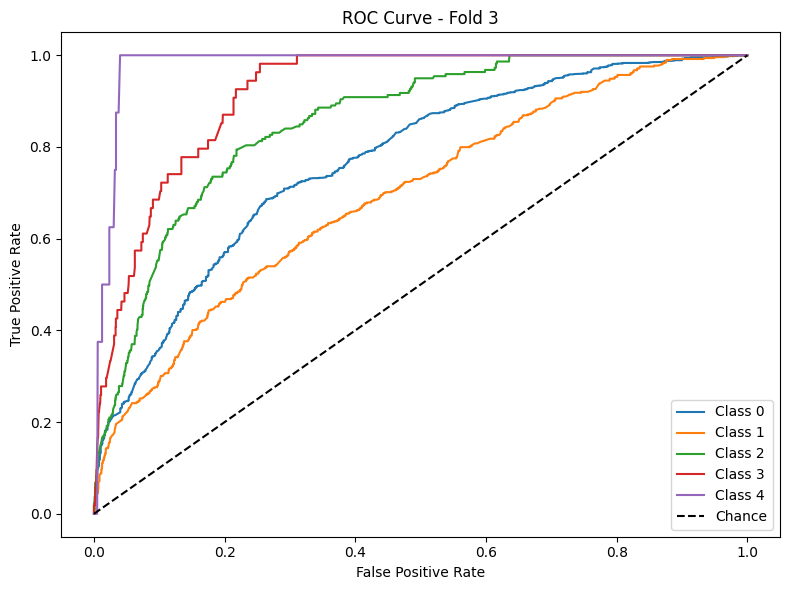

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 15ms/step - accuracy: 0.6229 - loss: 1.1165 - val_accuracy: 0.6614 - val_loss: 0.8969
Epoch 2/30
283/283 - 1s - 4ms/step - accuracy: 0.6681 - loss: 0.8672 - val_accuracy: 0.6742 - val_loss: 0.8299
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6779 - loss: 0.8301 - val_accuracy: 0.6839 - val_loss: 0.8078
Epoch 4/30
283/283 - 1s - 4ms/step - accuracy: 0.6795 - loss: 0.8122 - val_accuracy: 0.6835 - val_loss: 0.7988
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6819 - loss: 0.7980 - val_accuracy: 0.6901 - val_loss: 0.7920
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6851 - loss: 0.7922 - val_accuracy: 0.6870 - val_loss: 0.7857
Epoch 7/30
283/283 - 1s - 4ms/step - accuracy: 0.6851 - loss: 0.7858 - val_accuracy: 0.6888 - val_loss: 0.7817
Epoch 8/30
283/283 - 1s - 4ms/step - accuracy: 0.6832 - loss: 0.7813 - val_accuracy: 0.6910 - val_loss: 0.7765
Epoch 9/30
283/283 - 1s - 4ms/step - accuracy: 0.6905 - loss: 0.7704 - val_accuracy: 0.6910 - val_loss: 0.7807
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


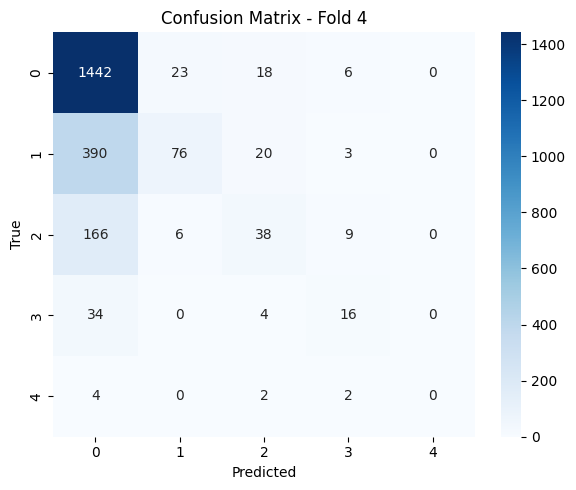

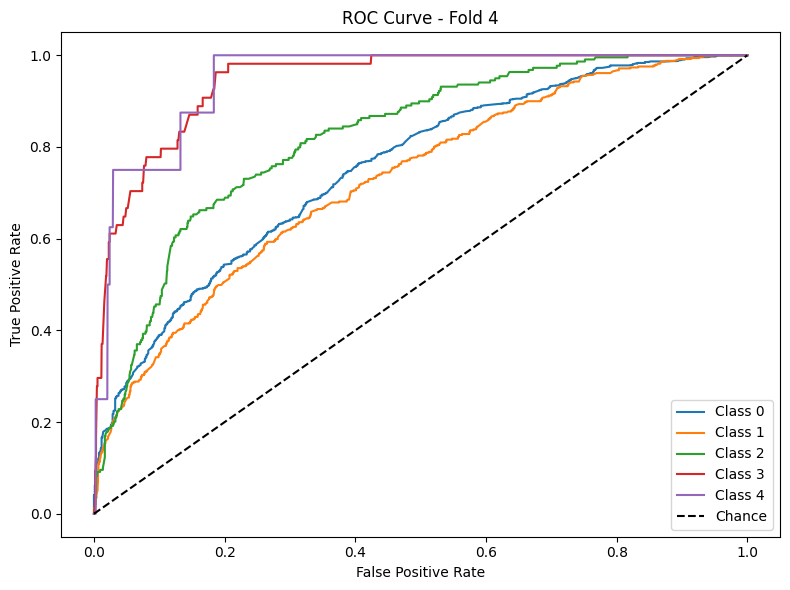

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 15ms/step - accuracy: 0.6175 - loss: 1.1222 - val_accuracy: 0.6600 - val_loss: 0.8898
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6711 - loss: 0.8664 - val_accuracy: 0.6804 - val_loss: 0.8319
Epoch 3/30
283/283 - 1s - 4ms/step - accuracy: 0.6798 - loss: 0.8262 - val_accuracy: 0.6822 - val_loss: 0.8100
Epoch 4/30
283/283 - 1s - 4ms/step - accuracy: 0.6790 - loss: 0.8147 - val_accuracy: 0.6870 - val_loss: 0.7993
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6808 - loss: 0.8007 - val_accuracy: 0.6822 - val_loss: 0.7934
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6854 - loss: 0.7891 - val_accuracy: 0.6866 - val_loss: 0.7841
Epoch 7/30
283/283 - 1s - 4ms/step - accuracy: 0.6895 - loss: 0.7815 - val_accuracy: 0.6861 - val_loss: 0.7880
Epoch 8/30
283/283 - 1s - 4ms/step - accuracy: 0.6871 - loss: 0.7785 - val_accuracy: 0.6866 - val_loss: 0.7778
Epoch 9/30
283/283 - 1s - 4ms/step - accuracy: 0.6861 - loss: 0.7723 - val_accuracy: 0.6879 - val_loss: 0.7699
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


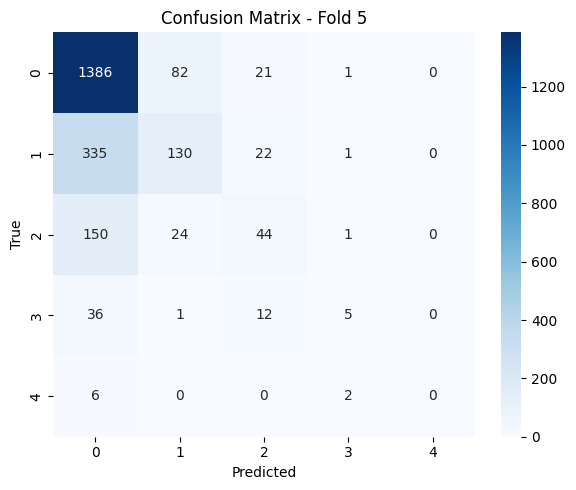

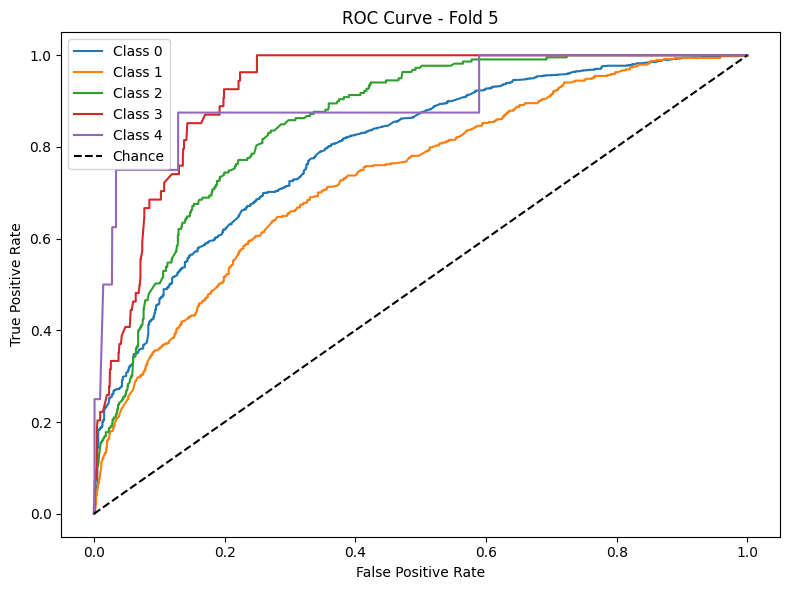


Average Accuracy: 0.6955
Average F1 Macro: 0.3247
Average AUC: 0.8417


======= Training Phase 3 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 16ms/step - accuracy: 0.6068 - loss: 1.1478 - val_accuracy: 0.6548 - val_loss: 0.9277
Epoch 2/30
260/260 - 1s - 4ms/step - accuracy: 0.6580 - loss: 0.8858 - val_accuracy: 0.6745 - val_loss: 0.8460
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6688 - loss: 0.8343 - val_accuracy: 0.6823 - val_loss: 0.8133
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6755 - loss: 0.8107 - val_accuracy: 0.6837 - val_loss: 0.7952
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6804 - loss: 0.7948 - val_accuracy: 0.6823 - val_loss: 0.7871
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6803 - loss: 0.7840 - val_accuracy: 0.6827 - val_loss: 0.7829
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6822 - loss: 0.7811 - val_accuracy: 0.6866 - val_loss: 0.7687
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6854 - loss: 0.7742 - val_accuracy: 0.6866 - val_loss: 0.7676
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6880 - loss: 0.7658 - val_accuracy: 0.6861 - val_loss: 0.7617
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


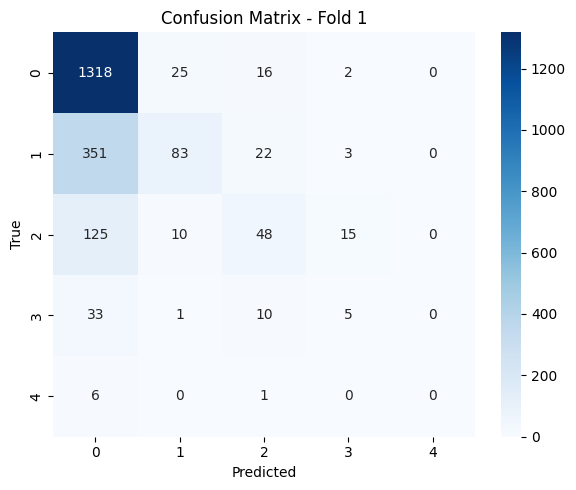

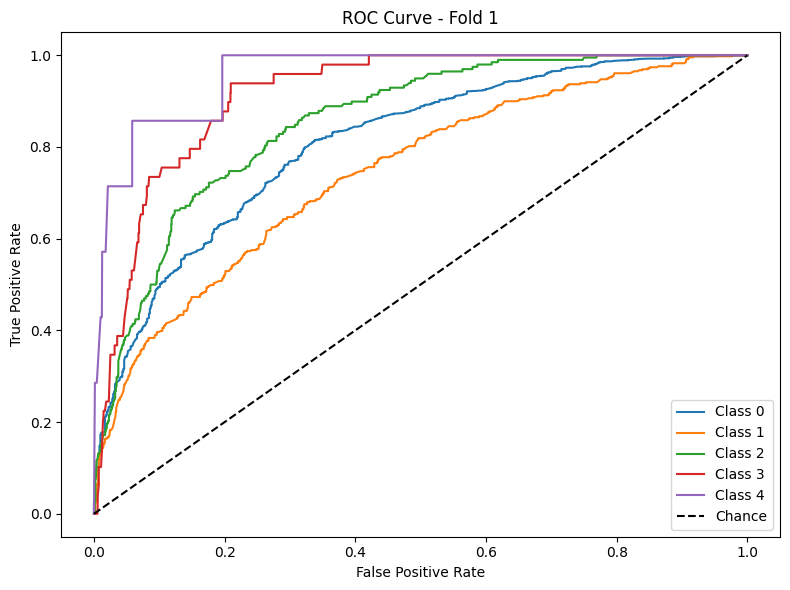

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
260/260 - 4s - 16ms/step - accuracy: 0.6200 - loss: 1.1272 - val_accuracy: 0.6572 - val_loss: 0.8987
Epoch 2/30
260/260 - 1s - 4ms/step - accuracy: 0.6641 - loss: 0.8771 - val_accuracy: 0.6663 - val_loss: 0.8344
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6733 - loss: 0.8318 - val_accuracy: 0.6707 - val_loss: 0.8133
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6767 - loss: 0.8117 - val_accuracy: 0.6745 - val_loss: 0.8028
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6772 - loss: 0.7985 - val_accuracy: 0.6813 - val_loss: 0.7952
Epoch 6/30
260/260 - 1s - 3ms/step - accuracy: 0.6817 - loss: 0.7912 - val_accuracy: 0.6818 - val_loss: 0.7926
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6841 - loss: 0.7790 - val_accuracy: 0.6895 - val_loss: 0.7854
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6886 - loss: 0.7734 - val_accuracy: 0.6895 - val_loss: 0.7843
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6867 - loss: 0.7655 - val_accuracy: 0.6943 - val_loss: 0.7767


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


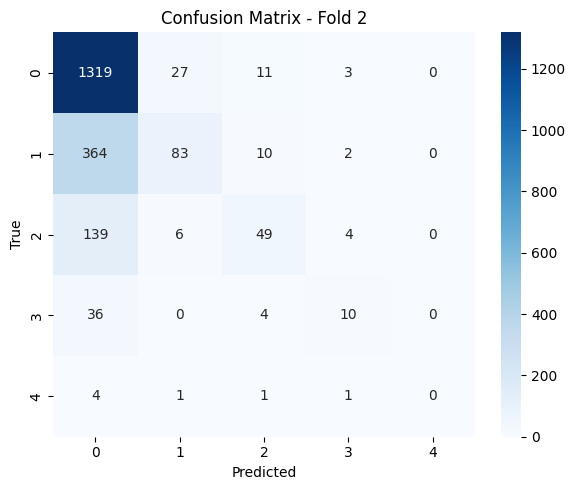

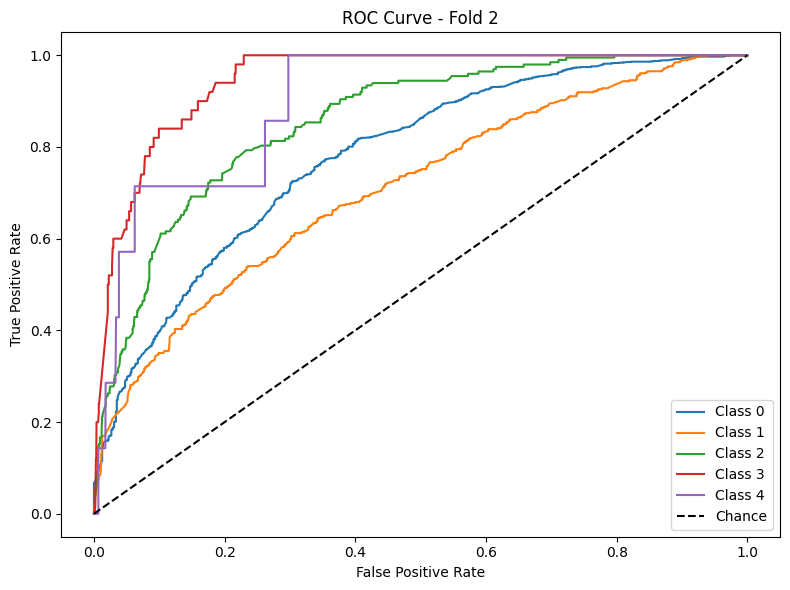

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 16ms/step - accuracy: 0.6263 - loss: 1.1232 - val_accuracy: 0.6591 - val_loss: 0.9069
Epoch 2/30
260/260 - 1s - 4ms/step - accuracy: 0.6623 - loss: 0.8750 - val_accuracy: 0.6808 - val_loss: 0.8375
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6756 - loss: 0.8277 - val_accuracy: 0.6818 - val_loss: 0.8131
Epoch 4/30
260/260 - 1s - 3ms/step - accuracy: 0.6778 - loss: 0.8095 - val_accuracy: 0.6861 - val_loss: 0.8014
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6788 - loss: 0.7965 - val_accuracy: 0.6827 - val_loss: 0.7955
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6843 - loss: 0.7837 - val_accuracy: 0.6808 - val_loss: 0.7867
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6800 - loss: 0.7731 - val_accuracy: 0.6885 - val_loss: 0.7795
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6827 - loss: 0.7729 - val_accuracy: 0.6914 - val_loss: 0.7737
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6843 - loss: 0.7669 - val_accuracy: 0.6962 - val_loss: 0.7655
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


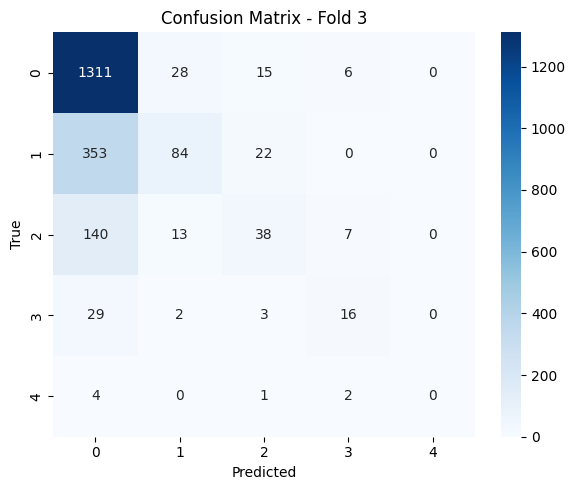

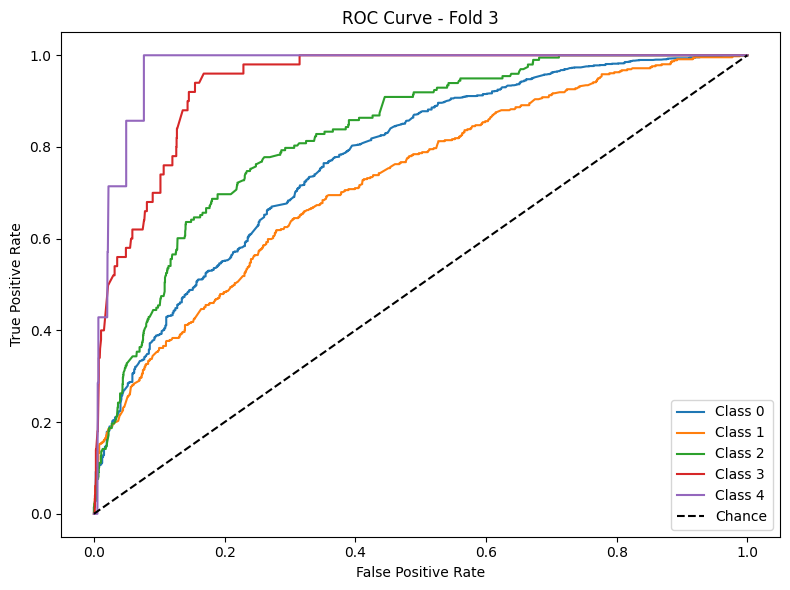

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 5s - 20ms/step - accuracy: 0.6245 - loss: 1.1329 - val_accuracy: 0.6591 - val_loss: 0.9163
Epoch 2/30
260/260 - 1s - 4ms/step - accuracy: 0.6697 - loss: 0.8705 - val_accuracy: 0.6765 - val_loss: 0.8512
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6757 - loss: 0.8302 - val_accuracy: 0.6736 - val_loss: 0.8262
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6807 - loss: 0.8093 - val_accuracy: 0.6774 - val_loss: 0.8162
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6837 - loss: 0.7941 - val_accuracy: 0.6760 - val_loss: 0.8087
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6860 - loss: 0.7838 - val_accuracy: 0.6760 - val_loss: 0.8003
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6839 - loss: 0.7829 - val_accuracy: 0.6770 - val_loss: 0.7989
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6846 - loss: 0.7732 - val_accuracy: 0.6789 - val_loss: 0.7954
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6862 - loss: 0.7662 - val_accuracy: 0.6861 - val_loss: 0.7841
Epoch 10/30

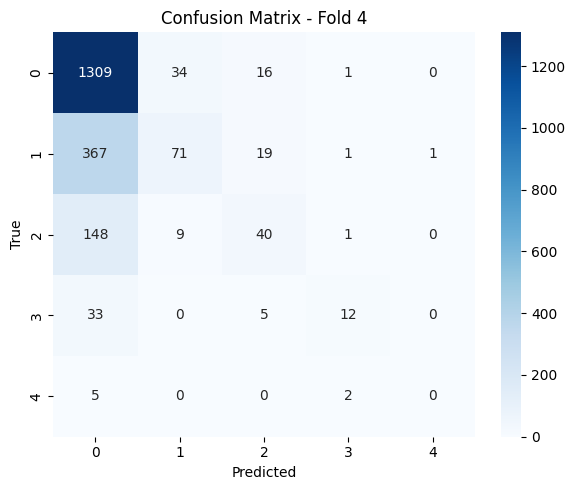

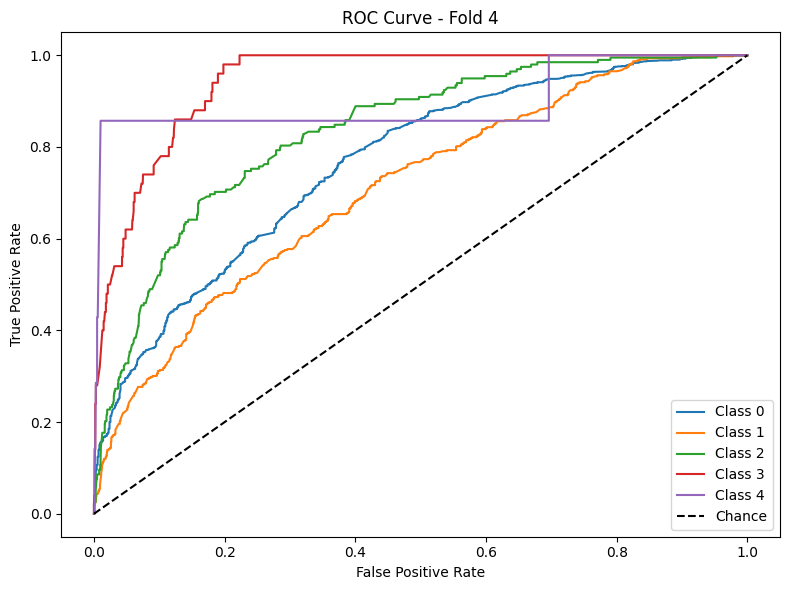

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 16ms/step - accuracy: 0.6219 - loss: 1.1315 - val_accuracy: 0.6556 - val_loss: 0.9147
Epoch 2/30
260/260 - 1s - 4ms/step - accuracy: 0.6627 - loss: 0.8793 - val_accuracy: 0.6647 - val_loss: 0.8455
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6771 - loss: 0.8262 - val_accuracy: 0.6768 - val_loss: 0.8223
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6772 - loss: 0.8059 - val_accuracy: 0.6749 - val_loss: 0.8094
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6845 - loss: 0.7949 - val_accuracy: 0.6758 - val_loss: 0.8062
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6835 - loss: 0.7857 - val_accuracy: 0.6797 - val_loss: 0.7951
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6872 - loss: 0.7760 - val_accuracy: 0.6821 - val_loss: 0.7887
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6903 - loss: 0.7666 - val_accuracy: 0.6807 - val_loss: 0.7865
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6937 - loss: 0.7571 - val_accuracy: 0.6797 - val_loss: 0.7850
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


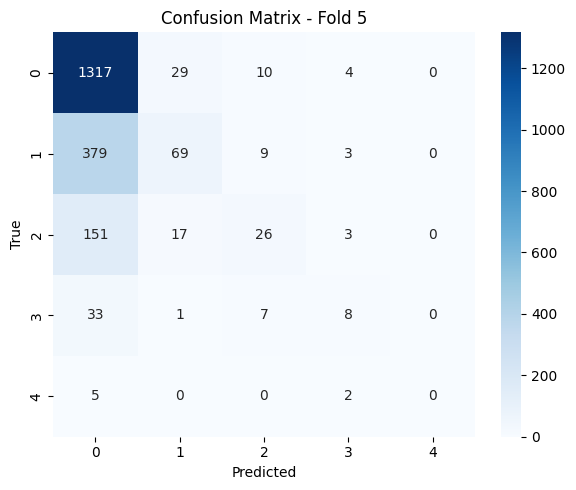

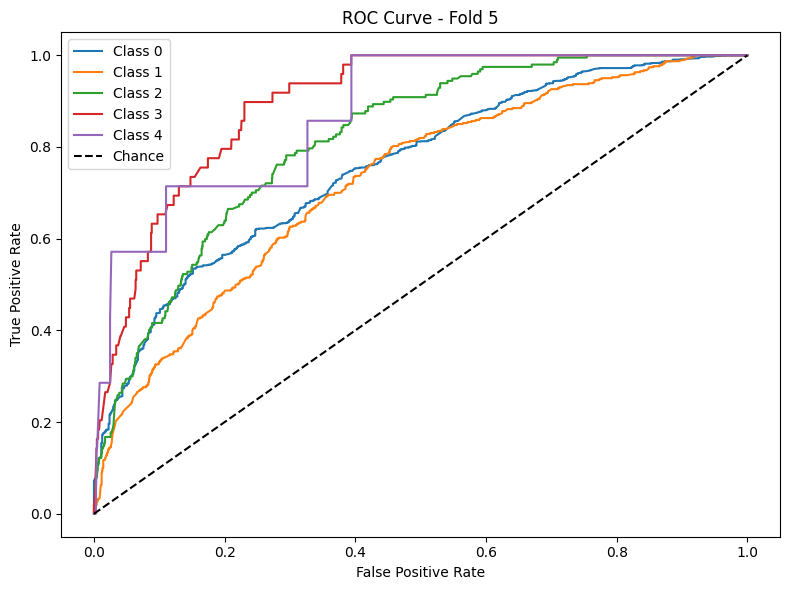


Average Accuracy: 0.6959
Average F1 Macro: 0.3320
Average AUC: 0.8373


======= Training Phase 4 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 5s - 26ms/step - accuracy: 0.6154 - loss: 1.2010 - val_accuracy: 0.6628 - val_loss: 0.9780
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6721 - loss: 0.9119 - val_accuracy: 0.6712 - val_loss: 0.8707
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6771 - loss: 0.8388 - val_accuracy: 0.6680 - val_loss: 0.8397
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6835 - loss: 0.8107 - val_accuracy: 0.6712 - val_loss: 0.8181
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6813 - loss: 0.7929 - val_accuracy: 0.6712 - val_loss: 0.8033
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.6906 - loss: 0.7812 - val_accuracy: 0.6725 - val_loss: 0.8011
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6921 - loss: 0.7685 - val_accuracy: 0.6764 - val_loss: 0.7921
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6908 - loss: 0.7654 - val_accuracy: 0.6777 - val_loss: 0.7897
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.6986 - loss: 0.7491 - val_accuracy: 0.6732 - val_loss: 0.7858
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


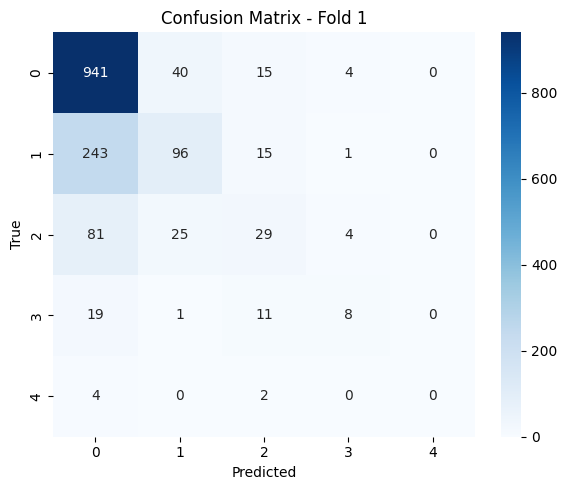

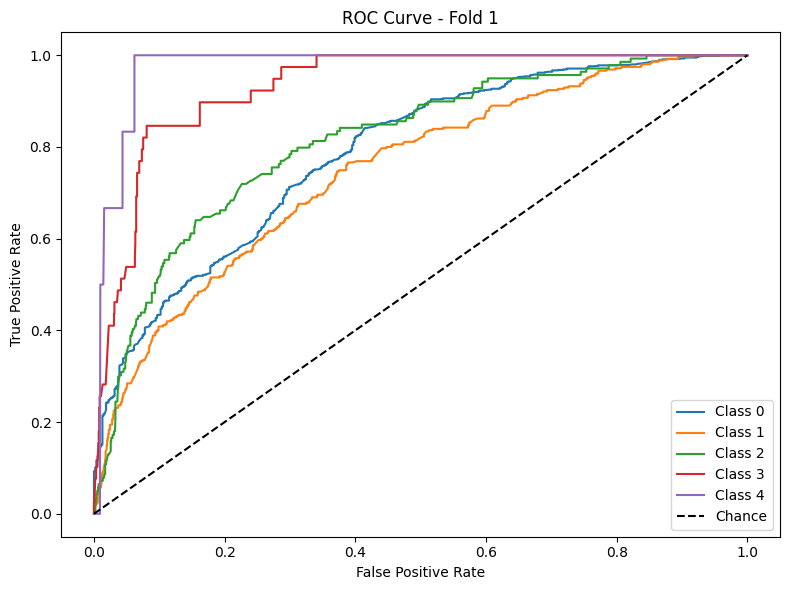

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 21ms/step - accuracy: 0.6215 - loss: 1.1775 - val_accuracy: 0.6706 - val_loss: 0.9562
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6666 - loss: 0.9033 - val_accuracy: 0.6693 - val_loss: 0.8479
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6727 - loss: 0.8378 - val_accuracy: 0.6771 - val_loss: 0.8193
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6786 - loss: 0.8085 - val_accuracy: 0.6738 - val_loss: 0.8013
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6784 - loss: 0.7904 - val_accuracy: 0.6881 - val_loss: 0.7868
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.6859 - loss: 0.7770 - val_accuracy: 0.6784 - val_loss: 0.7819
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6875 - loss: 0.7616 - val_accuracy: 0.6940 - val_loss: 0.7744
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6973 - loss: 0.7579 - val_accuracy: 0.6940 - val_loss: 0.7671
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.6978 - loss: 0.7494 - val_accuracy: 0.6946 - val_loss: 0.7658
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


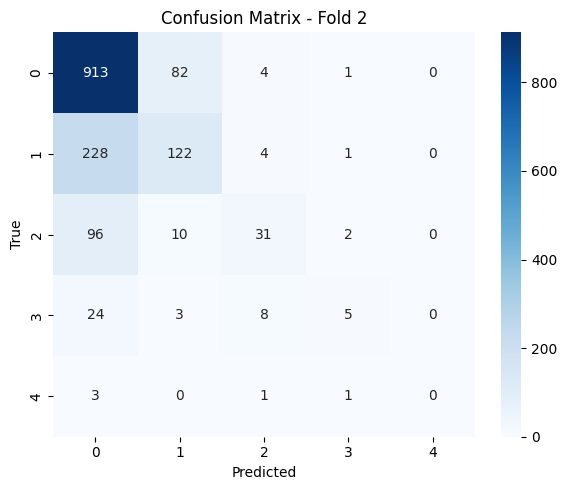

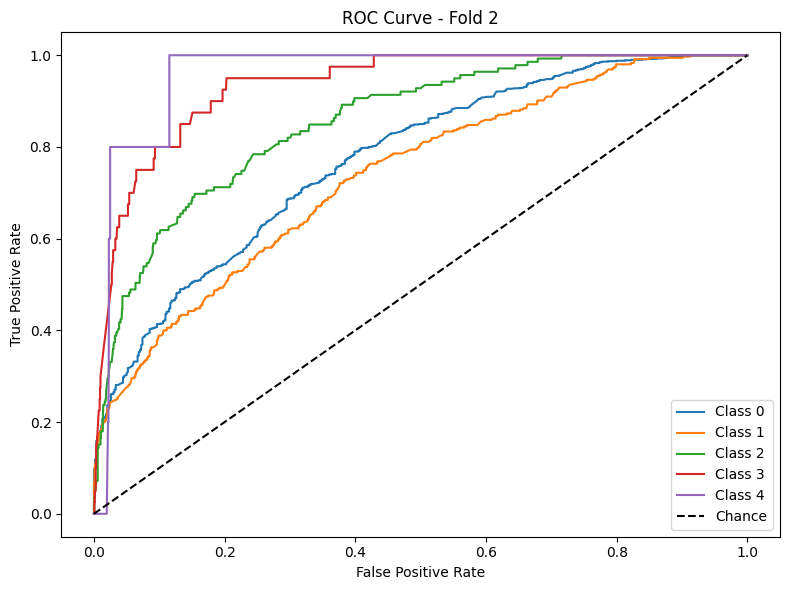

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 21ms/step - accuracy: 0.5897 - loss: 1.1967 - val_accuracy: 0.6615 - val_loss: 0.9629
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6708 - loss: 0.8945 - val_accuracy: 0.6660 - val_loss: 0.8658
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6748 - loss: 0.8211 - val_accuracy: 0.6745 - val_loss: 0.8349
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6864 - loss: 0.8024 - val_accuracy: 0.6777 - val_loss: 0.8144
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6888 - loss: 0.7833 - val_accuracy: 0.6810 - val_loss: 0.8093
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.6924 - loss: 0.7670 - val_accuracy: 0.6894 - val_loss: 0.7931
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6947 - loss: 0.7620 - val_accuracy: 0.6855 - val_loss: 0.7922
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6971 - loss: 0.7515 - val_accuracy: 0.6862 - val_loss: 0.7807
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.6989 - loss: 0.7427 - val_accuracy: 0.6927 - val_loss: 0.7777
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


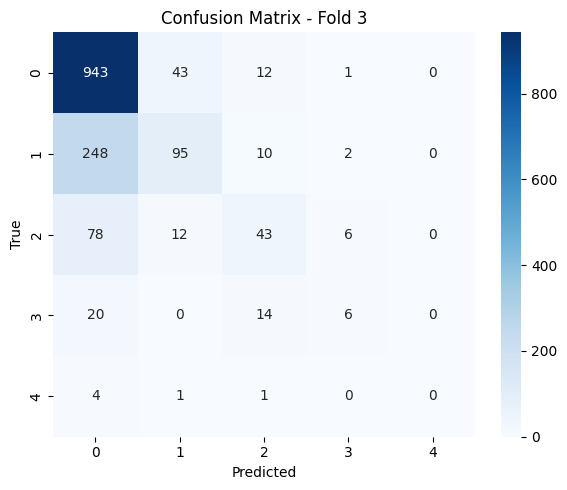

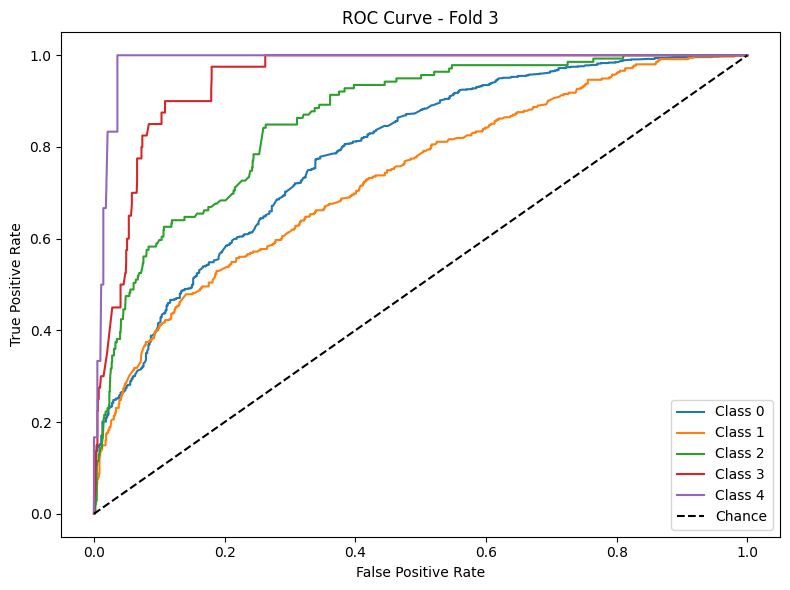

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 5s - 26ms/step - accuracy: 0.6102 - loss: 1.1775 - val_accuracy: 0.6710 - val_loss: 0.9654
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6648 - loss: 0.9017 - val_accuracy: 0.6704 - val_loss: 0.8569
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6739 - loss: 0.8351 - val_accuracy: 0.6788 - val_loss: 0.8226
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6768 - loss: 0.8075 - val_accuracy: 0.6756 - val_loss: 0.8048
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6884 - loss: 0.7925 - val_accuracy: 0.6795 - val_loss: 0.7992
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.6903 - loss: 0.7743 - val_accuracy: 0.6873 - val_loss: 0.7904
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6921 - loss: 0.7644 - val_accuracy: 0.6912 - val_loss: 0.7834
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6954 - loss: 0.7549 - val_accuracy: 0.6873 - val_loss: 0.7817
Epoch 9/30
193/193 - 1s - 5ms/step - accuracy: 0.6937 - loss: 0.7479 - val_accuracy: 0.6853 - val_loss: 0.7837
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


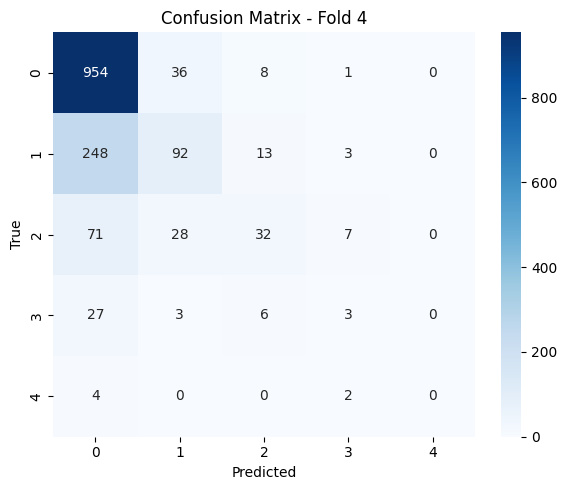

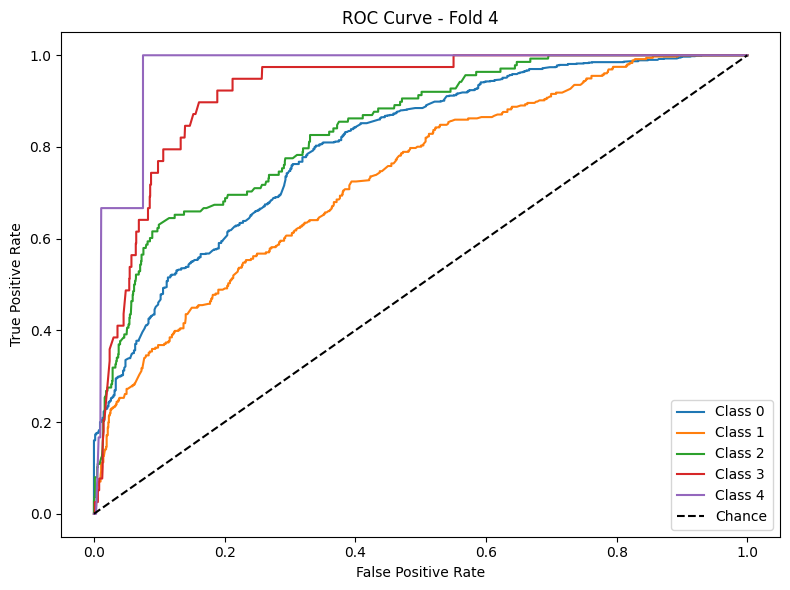

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 23ms/step - accuracy: 0.6125 - loss: 1.1921 - val_accuracy: 0.6671 - val_loss: 0.9542
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6650 - loss: 0.9100 - val_accuracy: 0.6769 - val_loss: 0.8492
Epoch 3/30
193/193 - 1s - 5ms/step - accuracy: 0.6729 - loss: 0.8469 - val_accuracy: 0.6769 - val_loss: 0.8108
Epoch 4/30
193/193 - 1s - 5ms/step - accuracy: 0.6780 - loss: 0.8191 - val_accuracy: 0.6847 - val_loss: 0.7914
Epoch 5/30
193/193 - 1s - 5ms/step - accuracy: 0.6786 - loss: 0.7946 - val_accuracy: 0.6866 - val_loss: 0.7772
Epoch 6/30
193/193 - 1s - 5ms/step - accuracy: 0.6855 - loss: 0.7858 - val_accuracy: 0.6860 - val_loss: 0.7722
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6916 - loss: 0.7687 - val_accuracy: 0.6905 - val_loss: 0.7719
Epoch 8/30
193/193 - 1s - 5ms/step - accuracy: 0.6934 - loss: 0.7648 - val_accuracy: 0.6873 - val_loss: 0.7595
Epoch 9/30
193/193 - 1s - 5ms/step - accuracy: 0.6944 - loss: 0.7525 - val_accuracy: 0.6899 - val_loss: 0.7512
Epoch 10/30

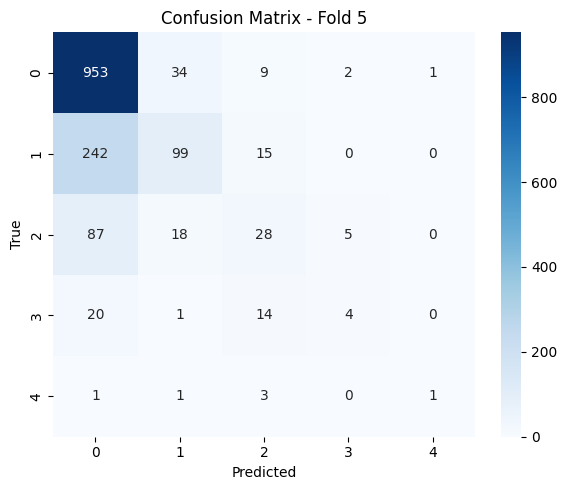

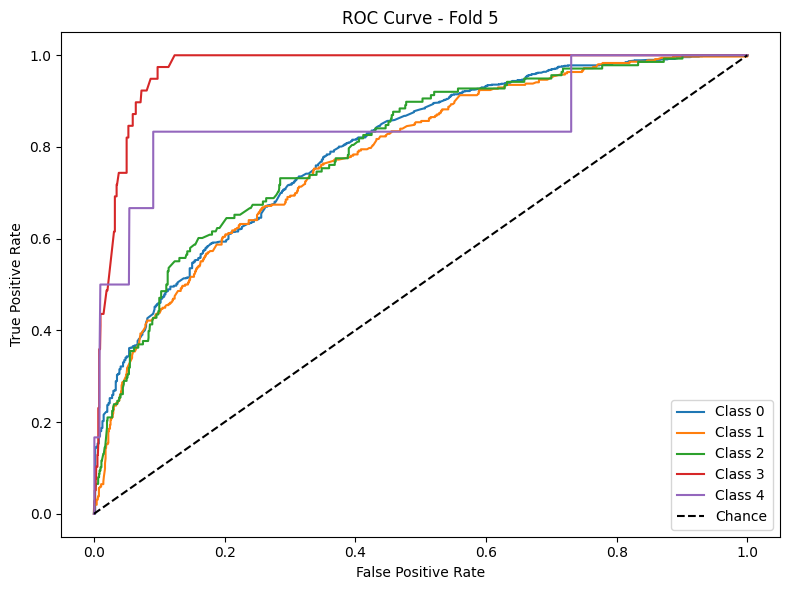


Average Accuracy: 0.7017
Average F1 Macro: 0.3538
Average AUC: 0.8516


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # Lưu model keras với .h5
    model.save(f"best_model_{temp}_phase{i}.h5")

    # Lưu scaler sklearn bình thường
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
from tensorflow.keras.models import load_model

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = load_model(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded'].values  # dạng mảng numpy
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # reshape cho LSTM input: (samples, timesteps=1, features)
    X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

    # Predict probabilities & labels
    y_pred_prob = model.predict(X_test_lstm)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Get unique classes from y_test (hoặc xác định từ dữ liệu train)
    classes = np.unique(np.concatenate((y_test, y_pred)))

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, labels=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       568
           1       0.35      0.24      0.28        63
           2       0.33      0.14      0.20        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.31      0.27      0.28       698
weighted avg       0.76      0.82      0.78       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


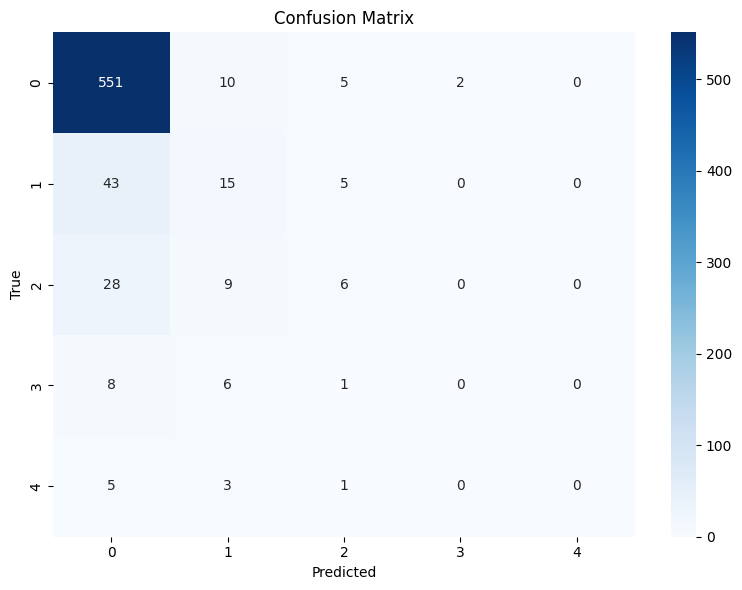


Test AUC (macro-average, OVR): 0.7587


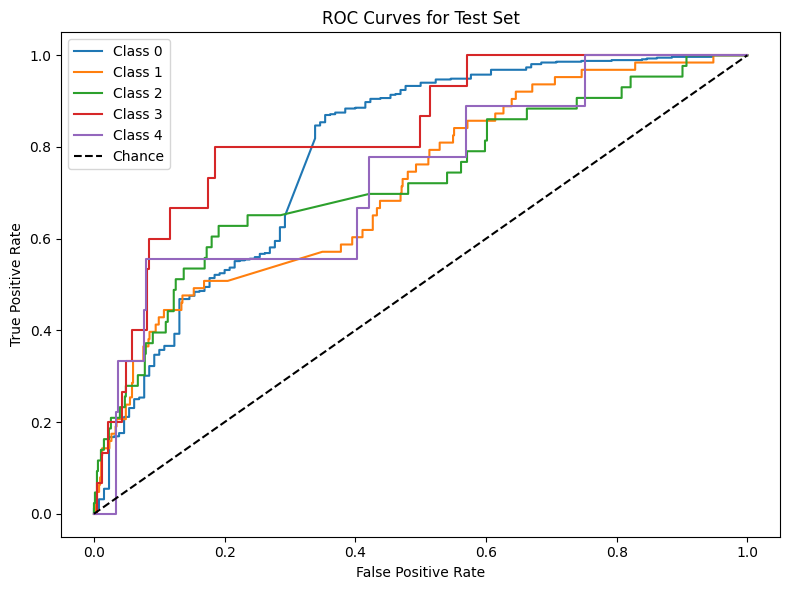

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       544
           1       0.28      0.17      0.21        59
           2       0.30      0.19      0.23        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.29      0.26      0.27       668
weighted avg       0.75      0.81      0.77       668



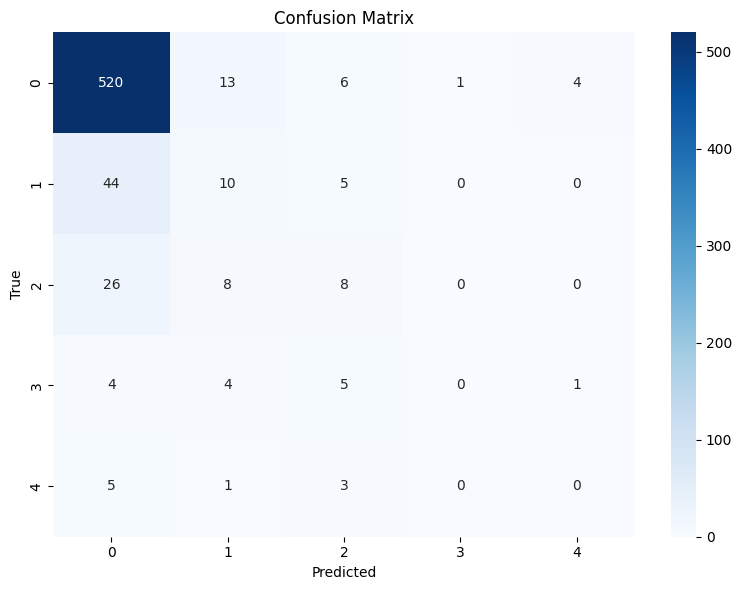


Test AUC (macro-average, OVR): 0.7596


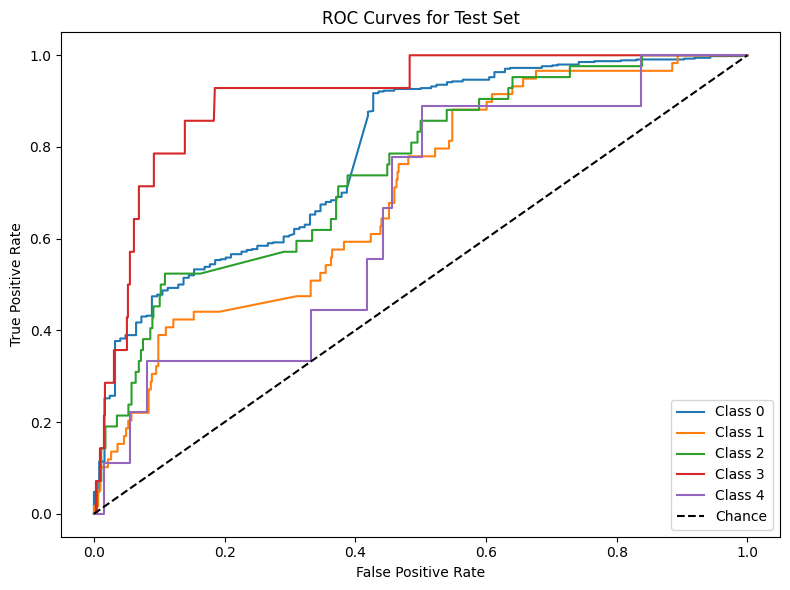

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       455
           1       0.39      0.13      0.20        52
           2       0.24      0.24      0.24        29
           3       1.00      0.10      0.18        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       554
   macro avg       0.50      0.29      0.31       554
weighted avg       0.79      0.83      0.80       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


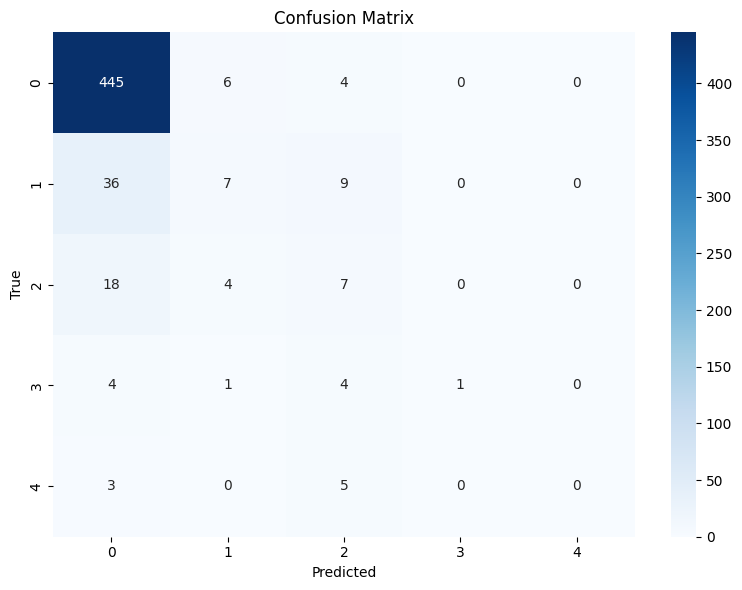


Test AUC (macro-average, OVR): 0.7615


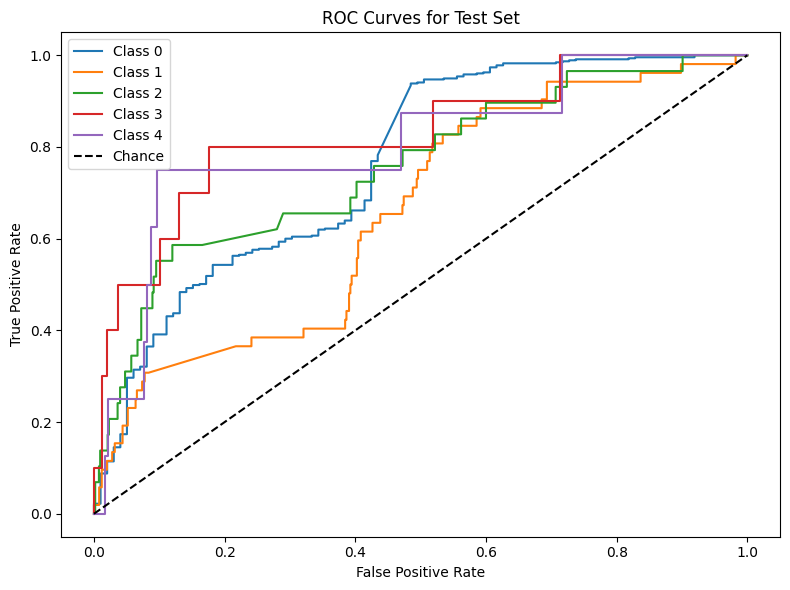

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       395
           1       0.29      0.15      0.20        40
           2       0.21      0.33      0.25        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.28      0.28      0.27       477
weighted avg       0.77      0.81      0.79       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


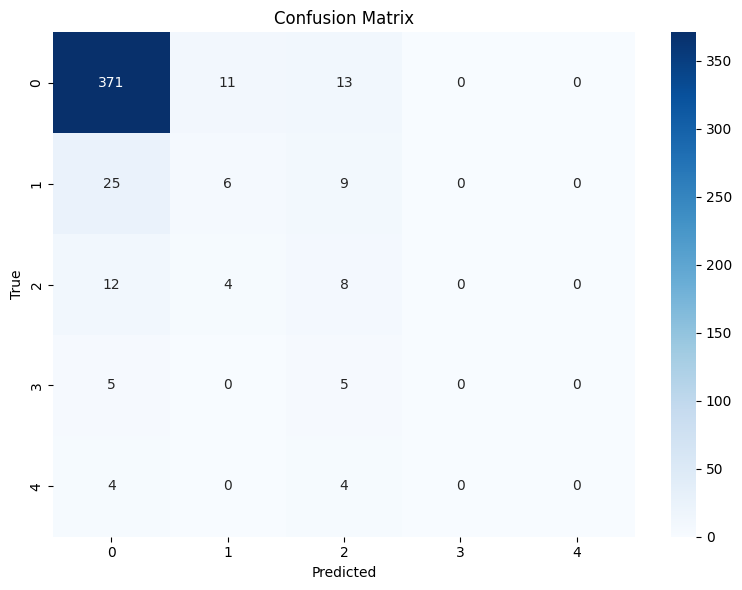


Test AUC (macro-average, OVR): 0.7662


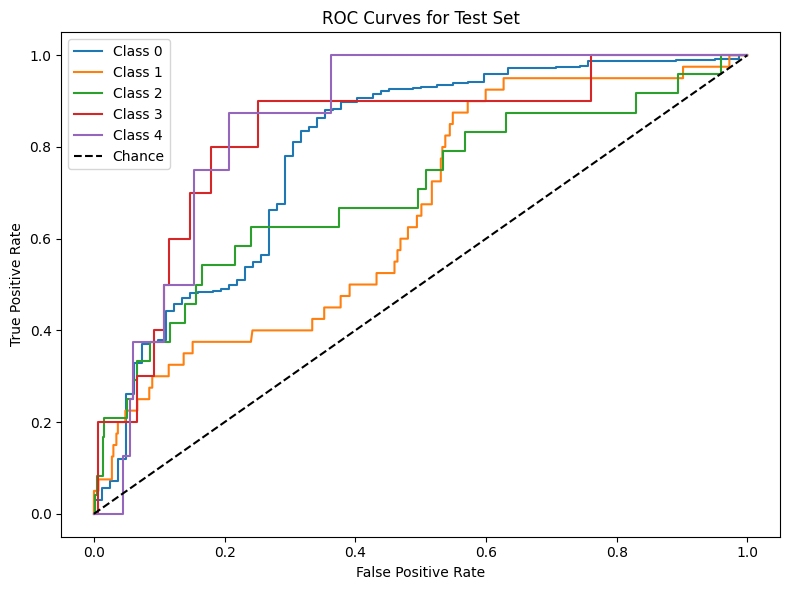

In [7]:
# import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)



import glob

# temp = "sample"  # hoặc "no_sample" tùy cách lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Add SMOTE Sample


=== Training Phase 1 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 7s - 7ms/step - accuracy: 0.5751 - loss: 1.0583 - val_accuracy: 0.5322 - val_loss: 1.0703
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6268 - loss: 0.8973 - val_accuracy: 0.5517 - val_loss: 1.0329
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6411 - loss: 0.8617 - val_accuracy: 0.5525 - val_loss: 1.0070
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6509 - loss: 0.8394 - val_accuracy: 0.5702 - val_loss: 0.9934
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6601 - loss: 0.8216 - val_accuracy: 0.6210 - val_loss: 0.9482
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6668 - loss: 0.8082 - val_accuracy: 0.6029 - val_loss: 0.9565
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6696 - loss: 0.7984 - val_accuracy: 0.5812 - val_loss: 0.9493
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.6729 - loss: 0.7936 - val_accuracy: 0.6155 - val_loss: 0.9321
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.6783 - loss: 0.7786 - val_accuracy: 0.6217 - val_loss: 0.9295
Epoch 10/30


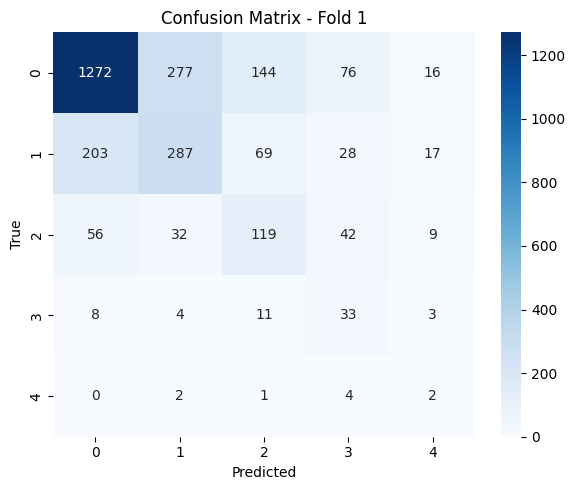

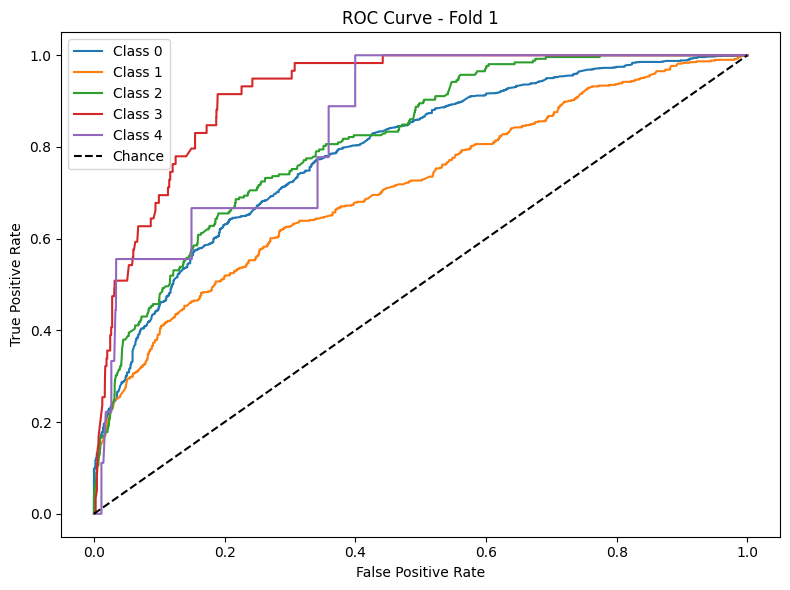

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 6ms/step - accuracy: 0.5840 - loss: 1.0380 - val_accuracy: 0.5214 - val_loss: 1.0764
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6430 - loss: 0.8686 - val_accuracy: 0.5273 - val_loss: 1.0220
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6610 - loss: 0.8313 - val_accuracy: 0.5538 - val_loss: 1.0066
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6688 - loss: 0.8125 - val_accuracy: 0.5450 - val_loss: 1.0044
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6795 - loss: 0.7931 - val_accuracy: 0.5707 - val_loss: 0.9670
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6831 - loss: 0.7825 - val_accuracy: 0.5833 - val_loss: 0.9403
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6867 - loss: 0.7717 - val_accuracy: 0.5567 - val_loss: 0.9854
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.6915 - loss: 0.7646 - val_accuracy: 0.5674 - val_loss: 0.9595
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.6939 - loss: 0.7601 - val_accuracy: 0.5777 - val_loss: 0.9512
Epoch 10/30


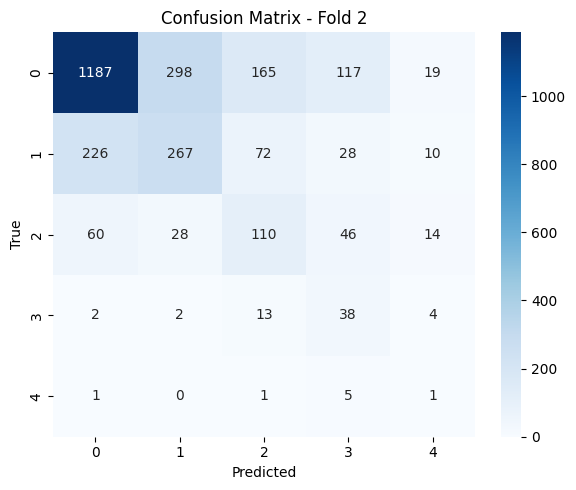

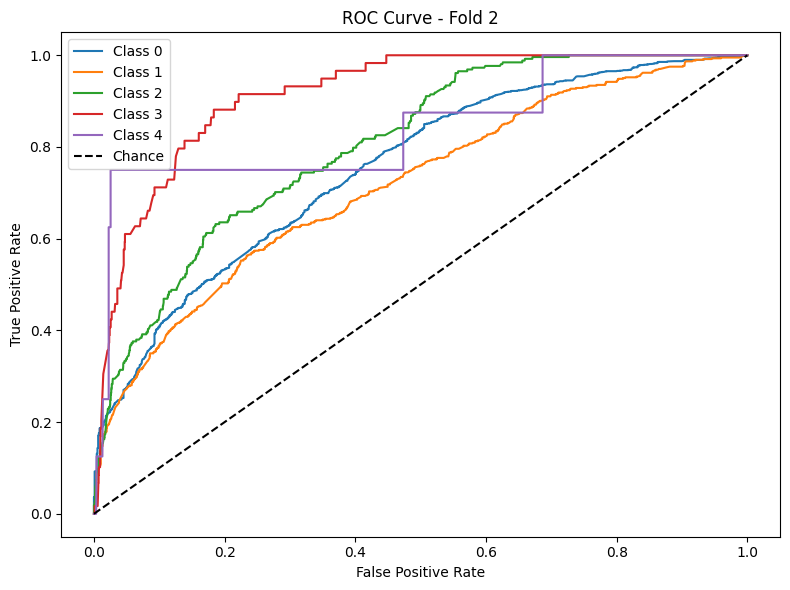

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 6ms/step - accuracy: 0.5762 - loss: 1.0584 - val_accuracy: 0.5420 - val_loss: 1.0562
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6405 - loss: 0.8853 - val_accuracy: 0.5287 - val_loss: 1.0364
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6571 - loss: 0.8444 - val_accuracy: 0.5427 - val_loss: 0.9953
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6661 - loss: 0.8233 - val_accuracy: 0.5700 - val_loss: 0.9662
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6689 - loss: 0.8082 - val_accuracy: 0.5862 - val_loss: 0.9450
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6742 - loss: 0.7981 - val_accuracy: 0.5663 - val_loss: 0.9806
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6768 - loss: 0.7901 - val_accuracy: 0.5748 - val_loss: 0.9655
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.6808 - loss: 0.7783 - val_accuracy: 0.5958 - val_loss: 0.9324
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.6868 - loss: 0.7725 - val_accuracy: 0.5663 - val_loss: 0.9661
Epoch 10/30


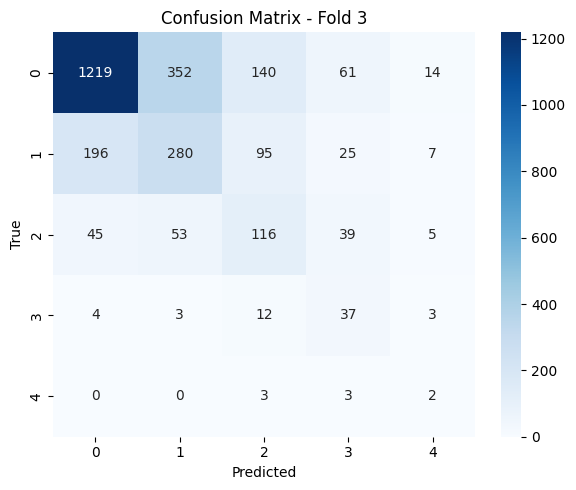

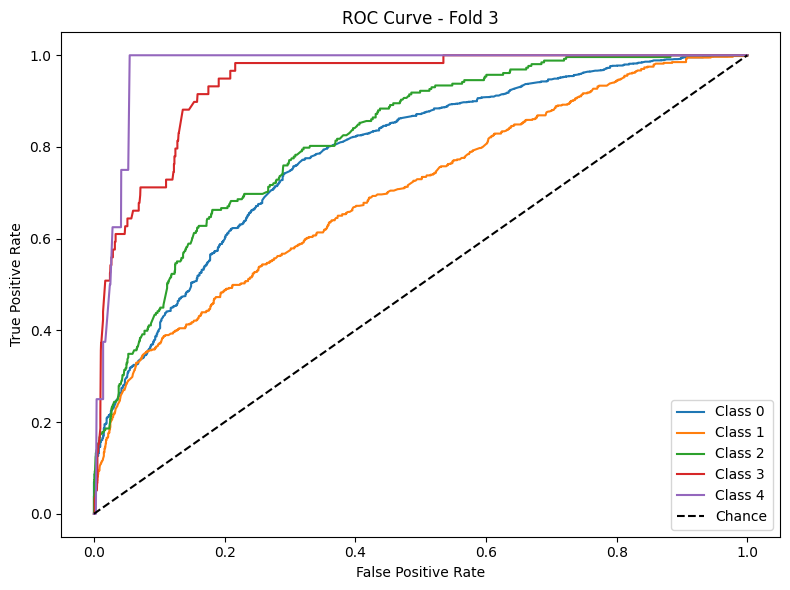

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 7s - 7ms/step - accuracy: 0.5788 - loss: 1.0642 - val_accuracy: 0.5391 - val_loss: 1.0664
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6454 - loss: 0.8732 - val_accuracy: 0.5077 - val_loss: 1.0426
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6566 - loss: 0.8338 - val_accuracy: 0.5413 - val_loss: 1.0025
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6675 - loss: 0.8117 - val_accuracy: 0.5796 - val_loss: 0.9605
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6788 - loss: 0.7950 - val_accuracy: 0.5803 - val_loss: 0.9546
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6807 - loss: 0.7813 - val_accuracy: 0.5564 - val_loss: 0.9621
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6860 - loss: 0.7726 - val_accuracy: 0.5516 - val_loss: 0.9641
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.6855 - loss: 0.7668 - val_accuracy: 0.6032 - val_loss: 0.9290
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.6922 - loss: 0.7579 - val_accuracy: 0.6109 - val_loss: 0.9330
Epoch 10/30


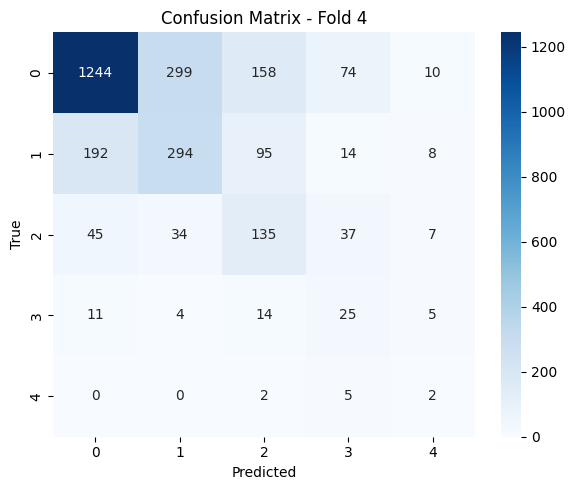

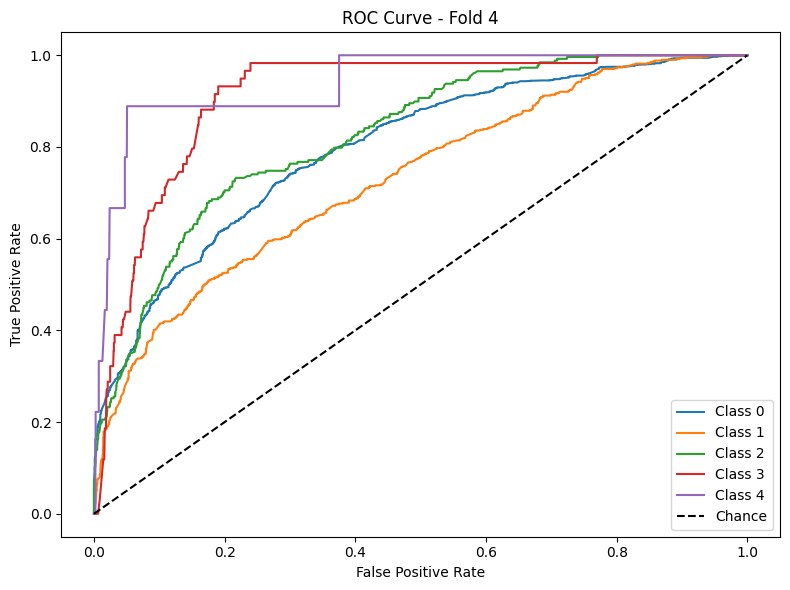

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 6ms/step - accuracy: 0.5793 - loss: 1.0412 - val_accuracy: 0.4790 - val_loss: 1.0505
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6445 - loss: 0.8735 - val_accuracy: 0.5210 - val_loss: 0.9937
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6562 - loss: 0.8394 - val_accuracy: 0.5685 - val_loss: 0.9796
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6675 - loss: 0.8179 - val_accuracy: 0.5929 - val_loss: 0.9312
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6730 - loss: 0.8016 - val_accuracy: 0.5851 - val_loss: 0.9507
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6807 - loss: 0.7886 - val_accuracy: 0.6054 - val_loss: 0.9364
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6803 - loss: 0.7851 - val_accuracy: 0.6046 - val_loss: 0.9404
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.6839 - loss: 0.7750 - val_accuracy: 0.5486 - val_loss: 0.9614
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.6874 - loss: 0.7650 - val_accuracy: 0.5707 - val_loss: 0.9342
85/85 ━━━━━━

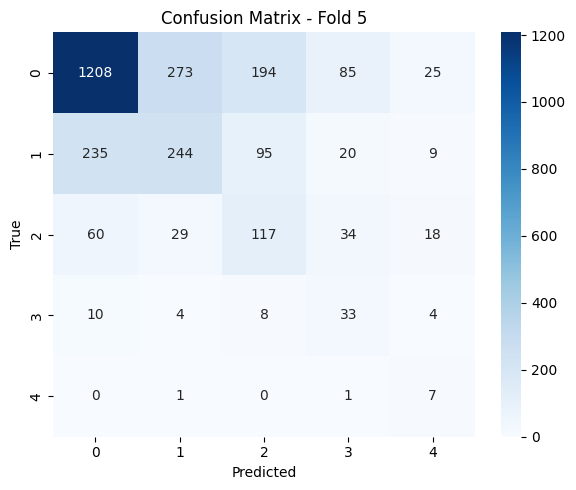

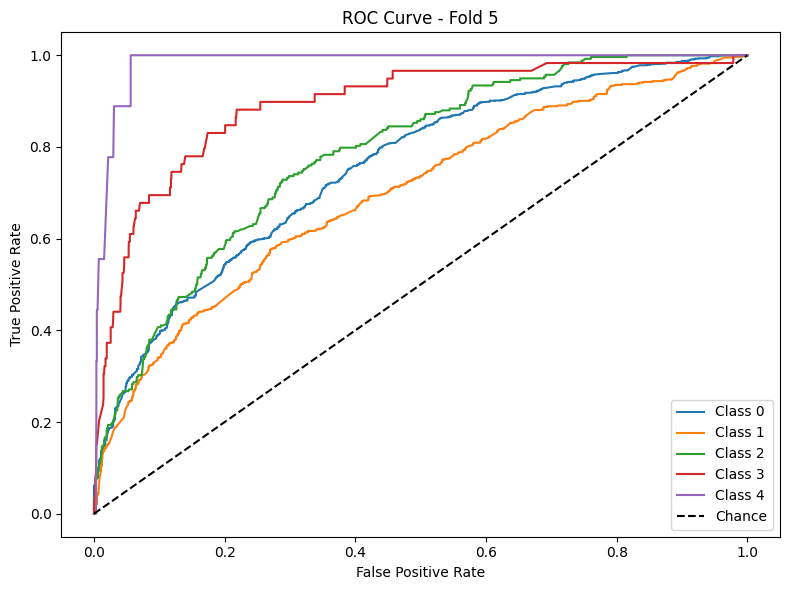


Average Accuracy: 0.6100
Average F1 Macro: 0.3900
Average AUC: 0.8260

=== Training Phase 2 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 6s - 7ms/step - accuracy: 0.5801 - loss: 1.0503 - val_accuracy: 0.4978 - val_loss: 1.1171
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.6536 - loss: 0.8552 - val_accuracy: 0.4925 - val_loss: 1.0627
Epoch 3/30
824/824 - 3s - 3ms/step - accuracy: 0.6656 - loss: 0.8114 - val_accuracy: 0.5544 - val_loss: 1.0015
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.6774 - loss: 0.7891 - val_accuracy: 0.5712 - val_loss: 0.9824
Epoch 5/30
824/824 - 3s - 3ms/step - accuracy: 0.6832 - loss: 0.7718 - val_accuracy: 0.6053 - val_loss: 0.9811
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.6935 - loss: 0.7626 - val_accuracy: 0.5973 - val_loss: 0.9596
Epoch 7/30
824/824 - 3s - 3ms/step - accuracy: 0.6959 - loss: 0.7509 - val_accuracy: 0.5774 - val_loss: 0.9844
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.6980 - loss: 0.7427 - val_accuracy: 0.6119 - val_loss: 0.9489
Epoch 9/30
824/824 - 3s - 3ms/step - accuracy: 0.7031 - loss: 0.7352 - val_accuracy: 0.6009 - val_loss: 0.9530
Epoch 10/30


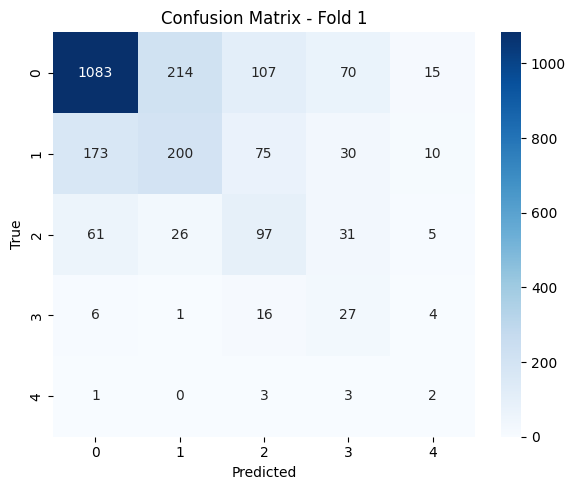

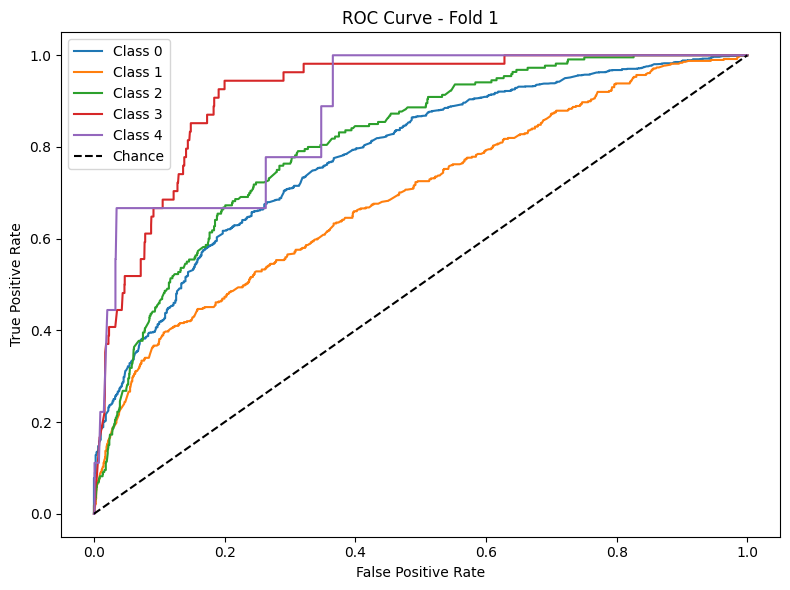

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 7s - 8ms/step - accuracy: 0.5883 - loss: 1.0458 - val_accuracy: 0.5235 - val_loss: 1.1111
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.6554 - loss: 0.8436 - val_accuracy: 0.5381 - val_loss: 1.0492
Epoch 3/30
824/824 - 3s - 3ms/step - accuracy: 0.6688 - loss: 0.8083 - val_accuracy: 0.5465 - val_loss: 1.0100
Epoch 4/30
824/824 - 3s - 3ms/step - accuracy: 0.6805 - loss: 0.7874 - val_accuracy: 0.5650 - val_loss: 1.0071
Epoch 5/30
824/824 - 3s - 3ms/step - accuracy: 0.6880 - loss: 0.7693 - val_accuracy: 0.5934 - val_loss: 0.9633
Epoch 6/30
824/824 - 3s - 3ms/step - accuracy: 0.6902 - loss: 0.7589 - val_accuracy: 0.5872 - val_loss: 0.9961
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.6952 - loss: 0.7500 - val_accuracy: 0.5925 - val_loss: 0.9623
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7000 - loss: 0.7411 - val_accuracy: 0.6049 - val_loss: 0.9516
Epoch 9/30
824/824 - 3s - 3ms/step - accuracy: 0.7030 - loss: 0.7313 - val_accuracy: 0.5876 - val_loss: 0.9727
Epoch 10/30


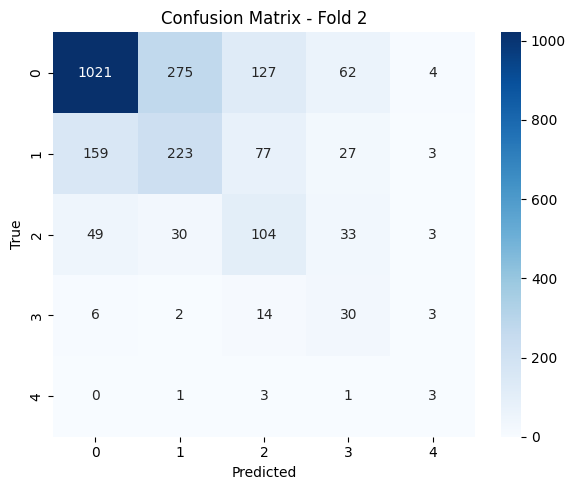

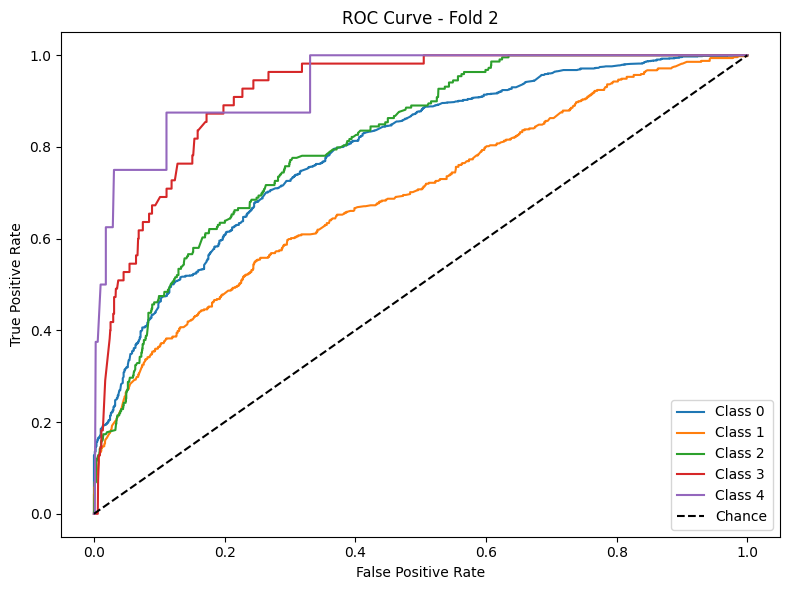

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 6s - 7ms/step - accuracy: 0.5823 - loss: 1.0381 - val_accuracy: 0.5060 - val_loss: 1.1180
Epoch 2/30
824/824 - 3s - 3ms/step - accuracy: 0.6581 - loss: 0.8467 - val_accuracy: 0.5108 - val_loss: 1.0826
Epoch 3/30
824/824 - 3s - 3ms/step - accuracy: 0.6689 - loss: 0.8072 - val_accuracy: 0.5060 - val_loss: 1.0498
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.6795 - loss: 0.7858 - val_accuracy: 0.5175 - val_loss: 1.0427
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.6850 - loss: 0.7693 - val_accuracy: 0.5724 - val_loss: 1.0077
Epoch 6/30
824/824 - 3s - 3ms/step - accuracy: 0.6943 - loss: 0.7580 - val_accuracy: 0.5378 - val_loss: 1.0268
Epoch 7/30
824/824 - 3s - 3ms/step - accuracy: 0.6971 - loss: 0.7466 - val_accuracy: 0.5618 - val_loss: 0.9917
Epoch 8/30
824/824 - 3s - 3ms/step - accuracy: 0.7040 - loss: 0.7356 - val_accuracy: 0.5352 - val_loss: 1.0002
Epoch 9/30
824/824 - 3s - 3ms/step - accuracy: 0.7037 - loss: 0.7329 - val_accuracy: 0.5808 - val_loss: 0.9686
Epoch 10/30


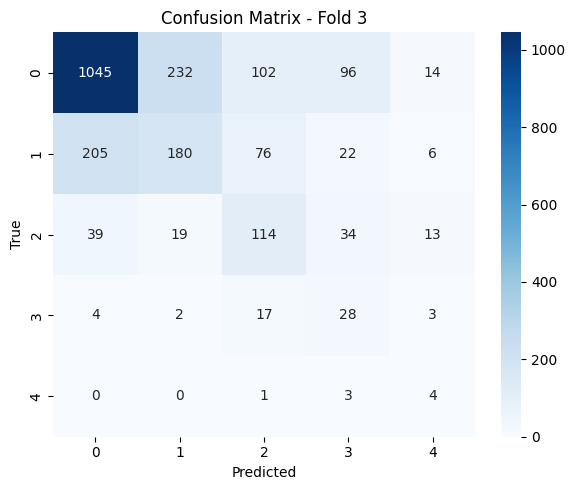

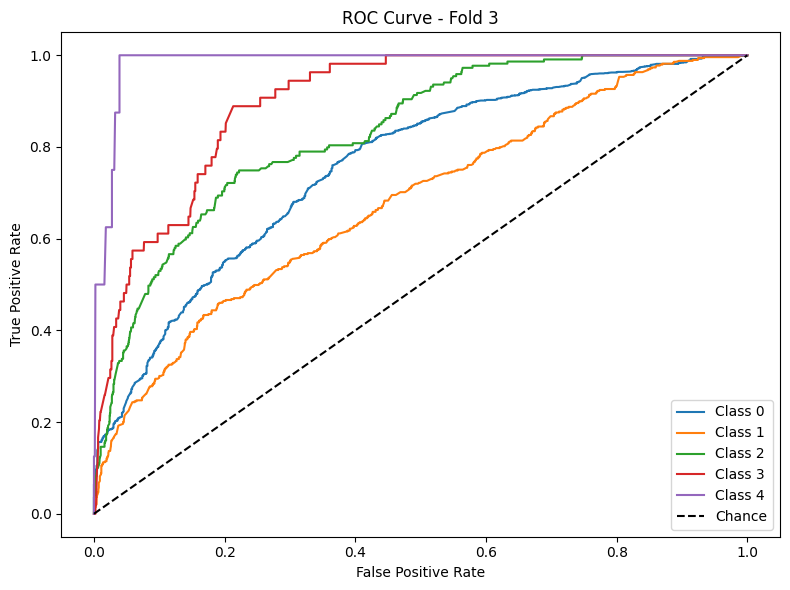

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 6s - 7ms/step - accuracy: 0.5785 - loss: 1.0828 - val_accuracy: 0.5175 - val_loss: 1.0761
Epoch 2/30
824/824 - 3s - 3ms/step - accuracy: 0.6339 - loss: 0.9055 - val_accuracy: 0.5414 - val_loss: 1.0109
Epoch 3/30
824/824 - 3s - 3ms/step - accuracy: 0.6487 - loss: 0.8629 - val_accuracy: 0.5268 - val_loss: 1.0101
Epoch 4/30
824/824 - 3s - 4ms/step - accuracy: 0.6610 - loss: 0.8377 - val_accuracy: 0.5870 - val_loss: 0.9624
Epoch 5/30
824/824 - 3s - 4ms/step - accuracy: 0.6705 - loss: 0.8203 - val_accuracy: 0.5640 - val_loss: 0.9587
Epoch 6/30
824/824 - 3s - 4ms/step - accuracy: 0.6765 - loss: 0.8076 - val_accuracy: 0.5919 - val_loss: 0.9341
Epoch 7/30
824/824 - 3s - 3ms/step - accuracy: 0.6818 - loss: 0.7962 - val_accuracy: 0.6003 - val_loss: 0.9209
Epoch 8/30
824/824 - 3s - 3ms/step - accuracy: 0.6853 - loss: 0.7894 - val_accuracy: 0.5892 - val_loss: 0.9379
Epoch 9/30
824/824 - 3s - 3ms/step - accuracy: 0.6891 - loss: 0.7775 - val_accuracy: 0.6078 - val_loss: 0.9282
Epoch 10/30


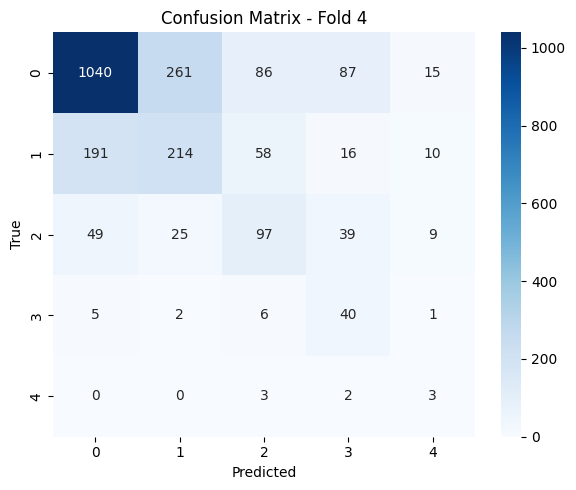

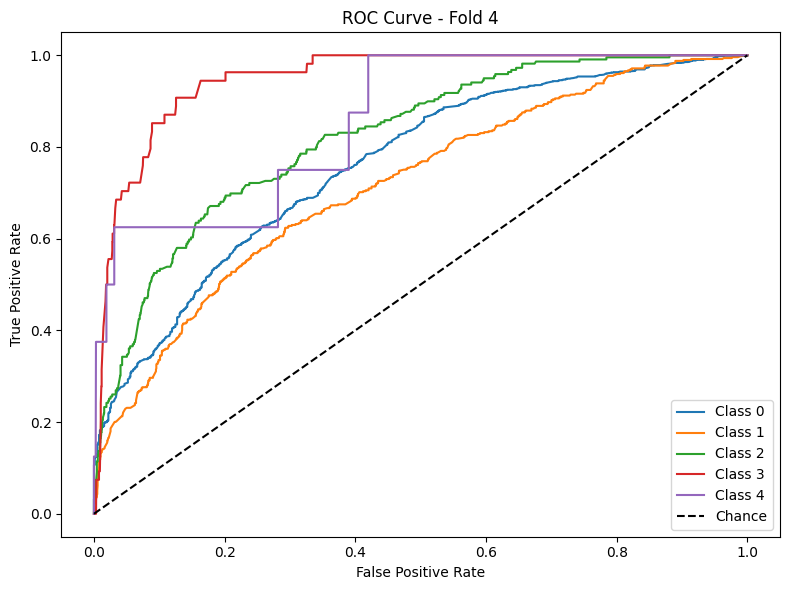

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 6s - 7ms/step - accuracy: 0.5682 - loss: 1.0729 - val_accuracy: 0.5002 - val_loss: 1.1079
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.6476 - loss: 0.8772 - val_accuracy: 0.5587 - val_loss: 1.0178
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.6611 - loss: 0.8381 - val_accuracy: 0.5232 - val_loss: 1.0395
Epoch 4/30
824/824 - 3s - 3ms/step - accuracy: 0.6756 - loss: 0.8115 - val_accuracy: 0.5396 - val_loss: 1.0193
Epoch 5/30
824/824 - 3s - 3ms/step - accuracy: 0.6833 - loss: 0.7956 - val_accuracy: 0.5715 - val_loss: 0.9913
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.6872 - loss: 0.7855 - val_accuracy: 0.5609 - val_loss: 0.9801
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.6925 - loss: 0.7733 - val_accuracy: 0.5764 - val_loss: 0.9823
Epoch 8/30
824/824 - 3s - 3ms/step - accuracy: 0.6960 - loss: 0.7659 - val_accuracy: 0.5892 - val_loss: 0.9784
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.6983 - loss: 0.7584 - val_accuracy: 0.5812 - val_loss: 0.9597
Epoch 10/30


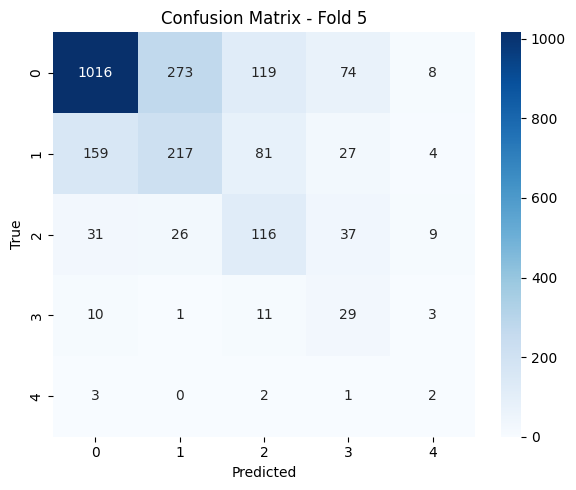

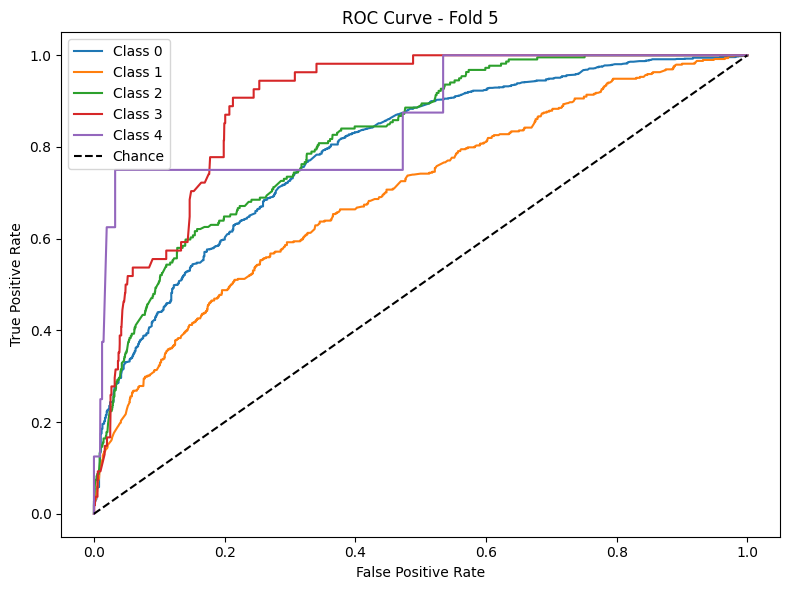


Average Accuracy: 0.6139
Average F1 Macro: 0.4018
Average AUC: 0.8221

=== Training Phase 3 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 7s - 9ms/step - accuracy: 0.5815 - loss: 1.0496 - val_accuracy: 0.5039 - val_loss: 1.1118
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6587 - loss: 0.8474 - val_accuracy: 0.5574 - val_loss: 1.0205
Epoch 3/30
752/752 - 3s - 3ms/step - accuracy: 0.6756 - loss: 0.8019 - val_accuracy: 0.5636 - val_loss: 0.9943
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.6881 - loss: 0.7723 - val_accuracy: 0.5926 - val_loss: 0.9941
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.6984 - loss: 0.7571 - val_accuracy: 0.5839 - val_loss: 0.9750
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7071 - loss: 0.7397 - val_accuracy: 0.6162 - val_loss: 0.9539
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7116 - loss: 0.7311 - val_accuracy: 0.5829 - val_loss: 0.9985
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7156 - loss: 0.7192 - val_accuracy: 0.5800 - val_loss: 0.9933
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7192 - loss: 0.7132 - val_accuracy: 0.6128 - val_loss: 0.9482
Epoch 10/30


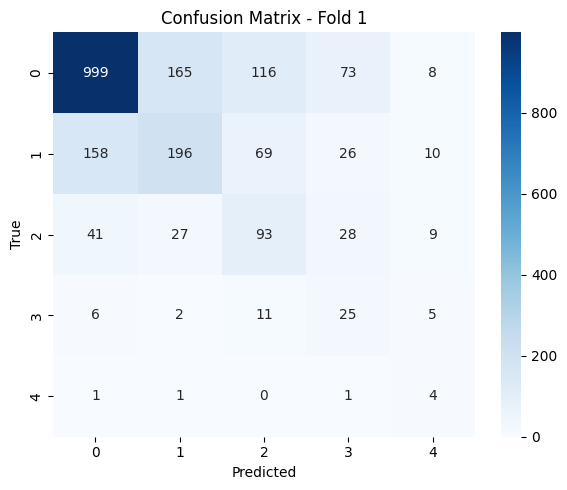

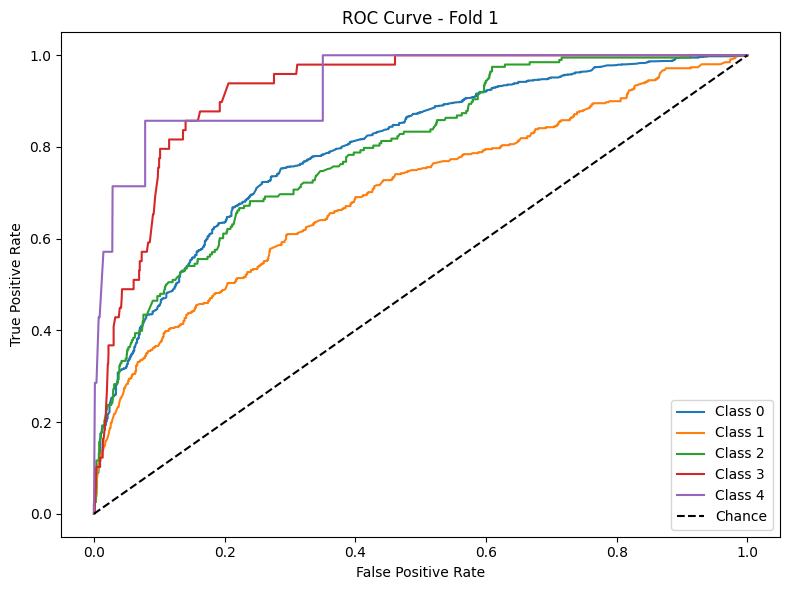

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 6s - 8ms/step - accuracy: 0.5892 - loss: 1.0563 - val_accuracy: 0.5260 - val_loss: 1.0937
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6492 - loss: 0.8602 - val_accuracy: 0.5207 - val_loss: 1.0510
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6693 - loss: 0.8170 - val_accuracy: 0.5849 - val_loss: 0.9869
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.6820 - loss: 0.7946 - val_accuracy: 0.5516 - val_loss: 0.9995
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.6908 - loss: 0.7784 - val_accuracy: 0.5935 - val_loss: 0.9666
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.6963 - loss: 0.7675 - val_accuracy: 0.5796 - val_loss: 0.9468
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7008 - loss: 0.7551 - val_accuracy: 0.5762 - val_loss: 0.9809
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7033 - loss: 0.7471 - val_accuracy: 0.5849 - val_loss: 0.9654
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7071 - loss: 0.7407 - val_accuracy: 0.5873 - val_loss: 0.9490
Epoch 10/30


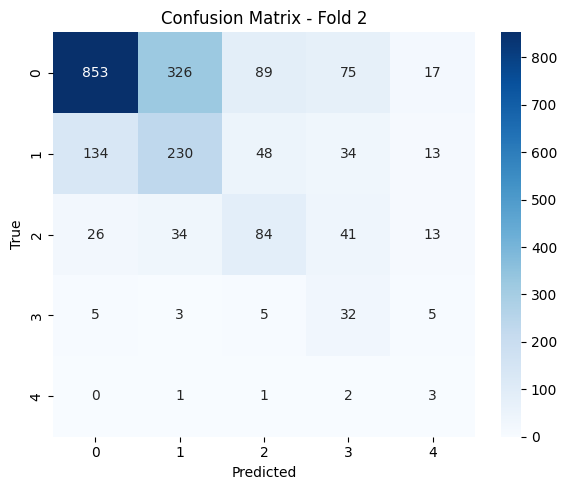

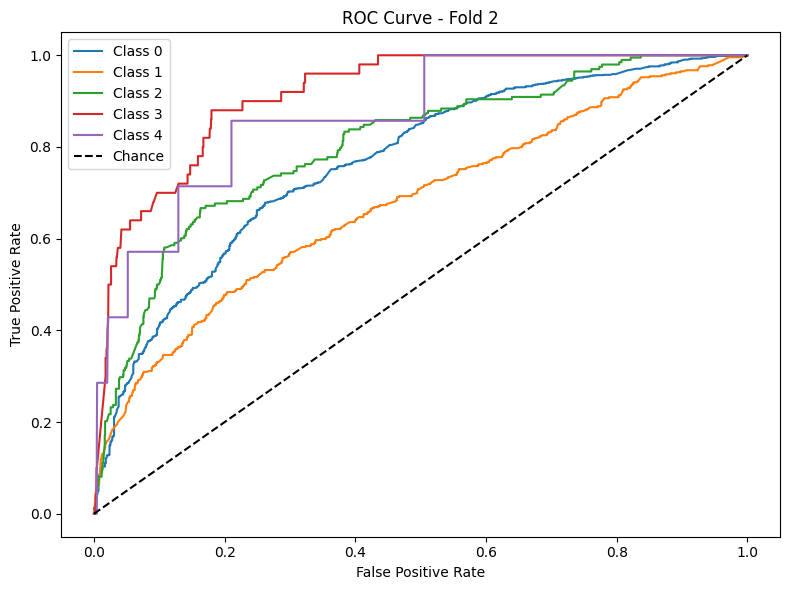

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 6s - 7ms/step - accuracy: 0.5813 - loss: 1.0727 - val_accuracy: 0.4990 - val_loss: 1.1091
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6589 - loss: 0.8618 - val_accuracy: 0.5410 - val_loss: 1.0708
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6812 - loss: 0.8145 - val_accuracy: 0.5444 - val_loss: 1.0316
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.6906 - loss: 0.7913 - val_accuracy: 0.5998 - val_loss: 0.9509
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.6973 - loss: 0.7695 - val_accuracy: 0.5733 - val_loss: 0.9907
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7041 - loss: 0.7583 - val_accuracy: 0.5781 - val_loss: 0.9829
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7077 - loss: 0.7467 - val_accuracy: 0.5892 - val_loss: 0.9762
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7086 - loss: 0.7398 - val_accuracy: 0.5743 - val_loss: 0.9952
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7137 - loss: 0.7320 - val_accuracy: 0.5834 - val_loss: 0.9714
65/65 ━━━━━━

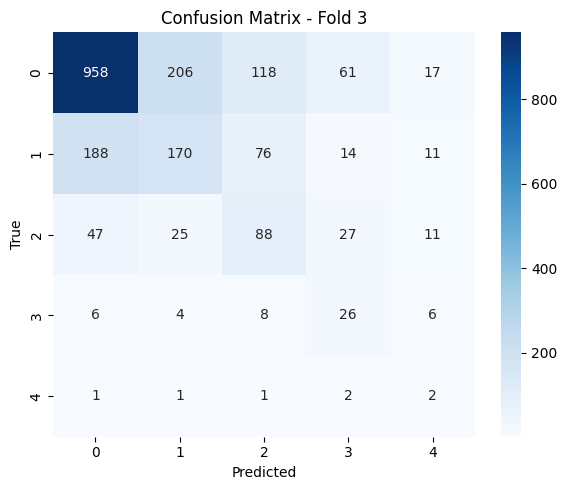

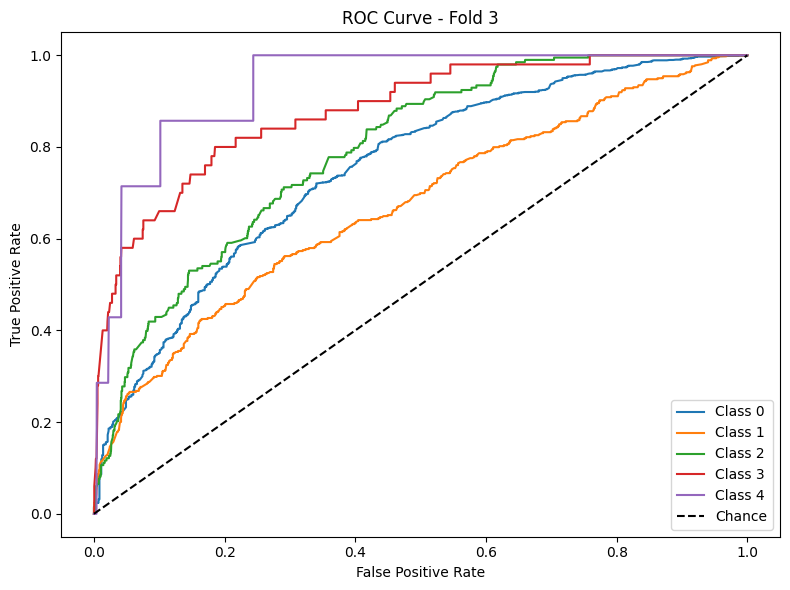

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 7s - 9ms/step - accuracy: 0.5896 - loss: 1.0382 - val_accuracy: 0.5159 - val_loss: 1.0939
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6634 - loss: 0.8590 - val_accuracy: 0.5458 - val_loss: 1.0168
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6793 - loss: 0.8166 - val_accuracy: 0.5603 - val_loss: 0.9872
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.6912 - loss: 0.7925 - val_accuracy: 0.5487 - val_loss: 0.9775
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7037 - loss: 0.7716 - val_accuracy: 0.5993 - val_loss: 0.9325
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7058 - loss: 0.7605 - val_accuracy: 0.5868 - val_loss: 0.9557
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7095 - loss: 0.7478 - val_accuracy: 0.5752 - val_loss: 0.9394
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7155 - loss: 0.7368 - val_accuracy: 0.6013 - val_loss: 0.9443
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7179 - loss: 0.7299 - val_accuracy: 0.6075 - val_loss: 0.9346
Epoch 10/30


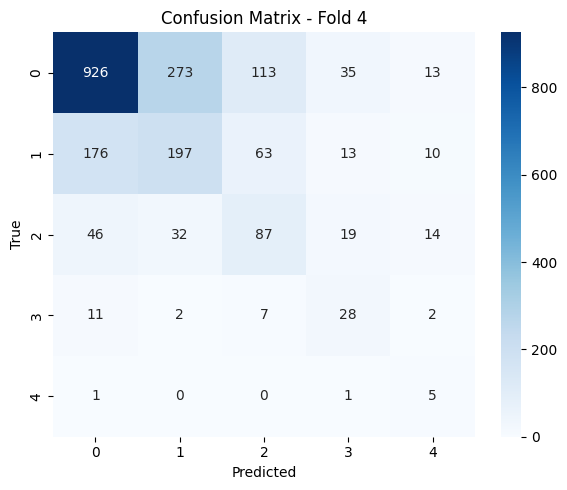

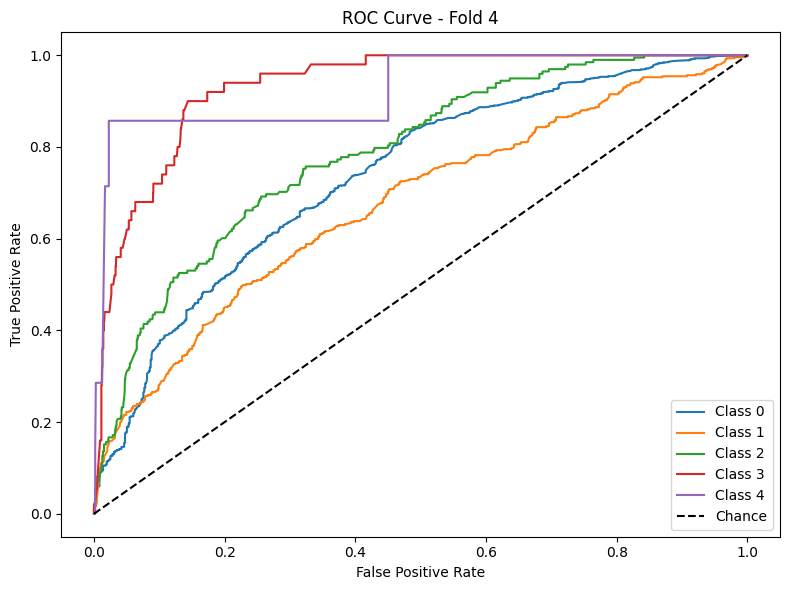

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 6s - 8ms/step - accuracy: 0.6050 - loss: 1.0259 - val_accuracy: 0.5432 - val_loss: 1.1087
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6688 - loss: 0.8366 - val_accuracy: 0.5630 - val_loss: 1.0368
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6859 - loss: 0.7925 - val_accuracy: 0.5605 - val_loss: 0.9958
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.6981 - loss: 0.7689 - val_accuracy: 0.5740 - val_loss: 1.0121
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7035 - loss: 0.7474 - val_accuracy: 0.5736 - val_loss: 1.0104
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7095 - loss: 0.7378 - val_accuracy: 0.5765 - val_loss: 1.0003
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7132 - loss: 0.7241 - val_accuracy: 0.6117 - val_loss: 0.9737
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7203 - loss: 0.7136 - val_accuracy: 0.5977 - val_loss: 0.9850
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7216 - loss: 0.7097 - val_accuracy: 0.5962 - val_loss: 0.9844
Epoch 10/30


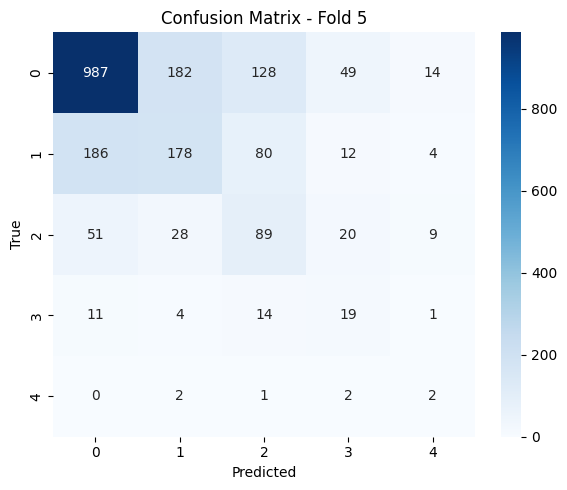

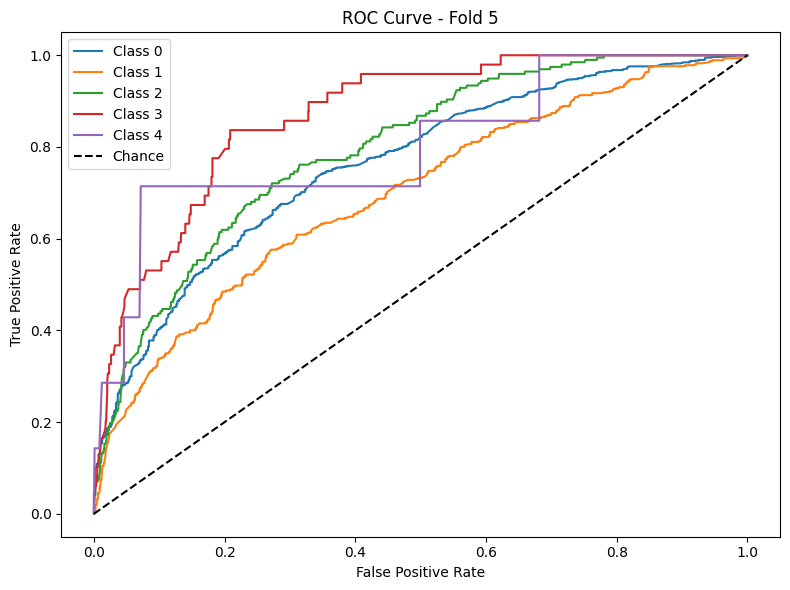


Average Accuracy: 0.6057
Average F1 Macro: 0.3931
Average AUC: 0.8074

=== Training Phase 4 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 9ms/step - accuracy: 0.5880 - loss: 1.0675 - val_accuracy: 0.5374 - val_loss: 1.1299
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.6881 - loss: 0.8127 - val_accuracy: 0.5887 - val_loss: 1.0422
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7116 - loss: 0.7563 - val_accuracy: 0.5718 - val_loss: 1.0230
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7229 - loss: 0.7242 - val_accuracy: 0.5549 - val_loss: 1.0407
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7317 - loss: 0.7028 - val_accuracy: 0.5699 - val_loss: 1.0070
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7362 - loss: 0.6832 - val_accuracy: 0.5867 - val_loss: 0.9785
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7390 - loss: 0.6701 - val_accuracy: 0.5939 - val_loss: 0.9542
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7470 - loss: 0.6575 - val_accuracy: 0.5718 - val_loss: 0.9888
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7496 - loss: 0.6456 - val_accuracy: 0.6030 - val_loss: 0.9688
Epoch 10/30


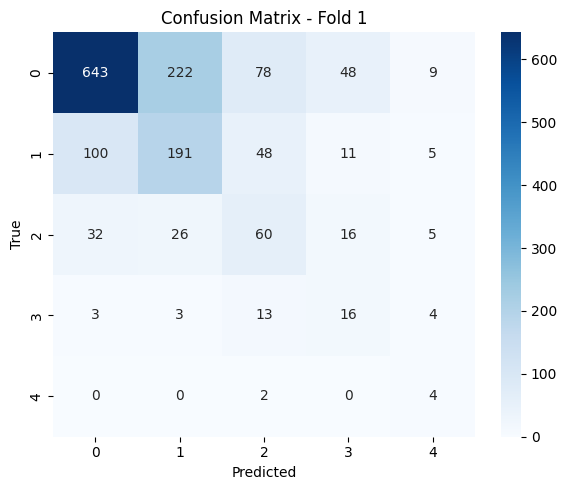

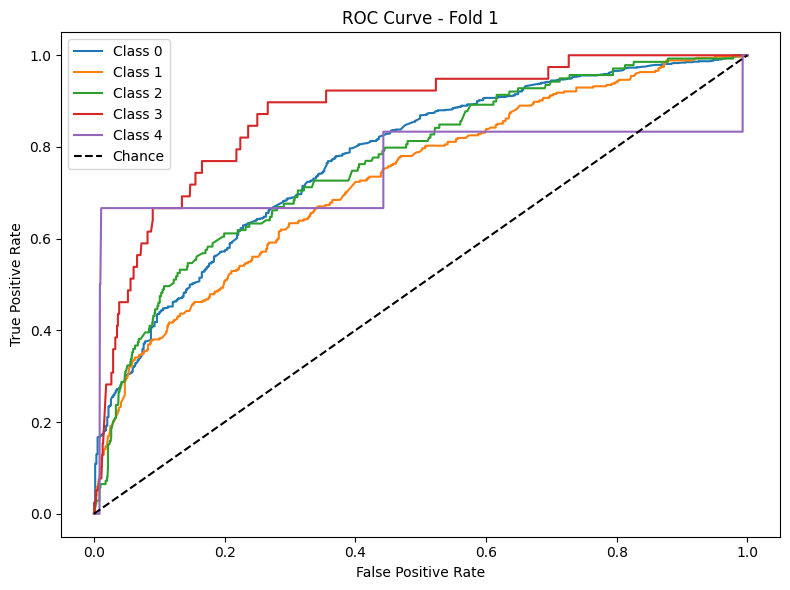

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 9ms/step - accuracy: 0.6226 - loss: 1.0296 - val_accuracy: 0.5400 - val_loss: 1.0939
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.6972 - loss: 0.7952 - val_accuracy: 0.5705 - val_loss: 1.0507
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7194 - loss: 0.7451 - val_accuracy: 0.6160 - val_loss: 0.9652
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7293 - loss: 0.7129 - val_accuracy: 0.5913 - val_loss: 0.9743
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7392 - loss: 0.6914 - val_accuracy: 0.5874 - val_loss: 0.9900
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7397 - loss: 0.6807 - val_accuracy: 0.6043 - val_loss: 0.9468
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7436 - loss: 0.6692 - val_accuracy: 0.5900 - val_loss: 0.9595
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7492 - loss: 0.6593 - val_accuracy: 0.5952 - val_loss: 0.9404
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7519 - loss: 0.6531 - val_accuracy: 0.6088 - val_loss: 0.9366
Epoch 10/30


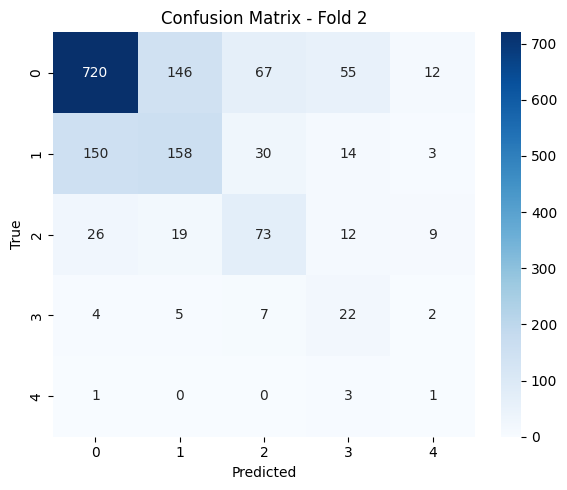

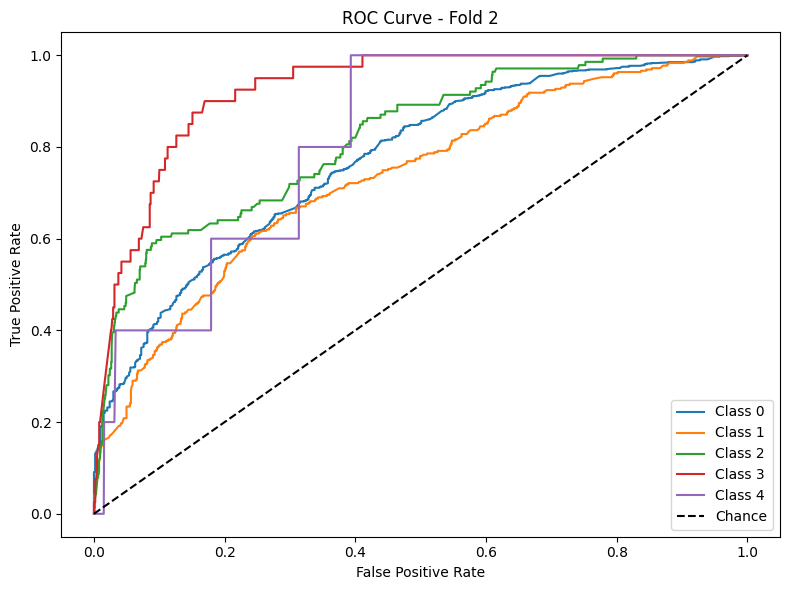

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 7s - 12ms/step - accuracy: 0.6023 - loss: 1.0520 - val_accuracy: 0.5354 - val_loss: 1.1079
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.6959 - loss: 0.7985 - val_accuracy: 0.5653 - val_loss: 1.0197
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7087 - loss: 0.7486 - val_accuracy: 0.5666 - val_loss: 1.0183
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7203 - loss: 0.7224 - val_accuracy: 0.5926 - val_loss: 1.0115
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7299 - loss: 0.6990 - val_accuracy: 0.6023 - val_loss: 0.9902
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7398 - loss: 0.6793 - val_accuracy: 0.6218 - val_loss: 0.9603
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7422 - loss: 0.6697 - val_accuracy: 0.6114 - val_loss: 0.9650
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7435 - loss: 0.6609 - val_accuracy: 0.5984 - val_loss: 0.9501
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7492 - loss: 0.6533 - val_accuracy: 0.6088 - val_loss: 0.9519
Epoch 10/30

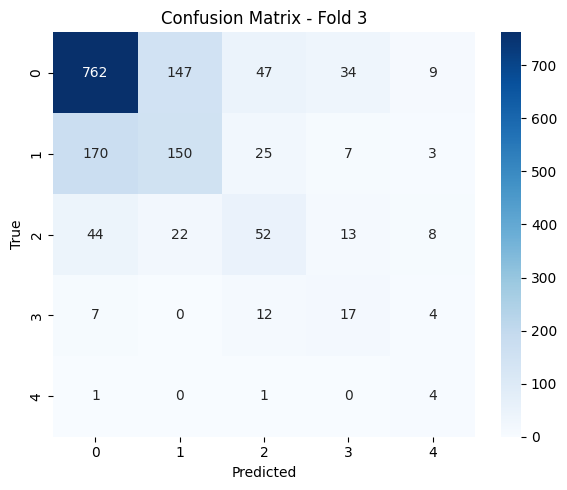

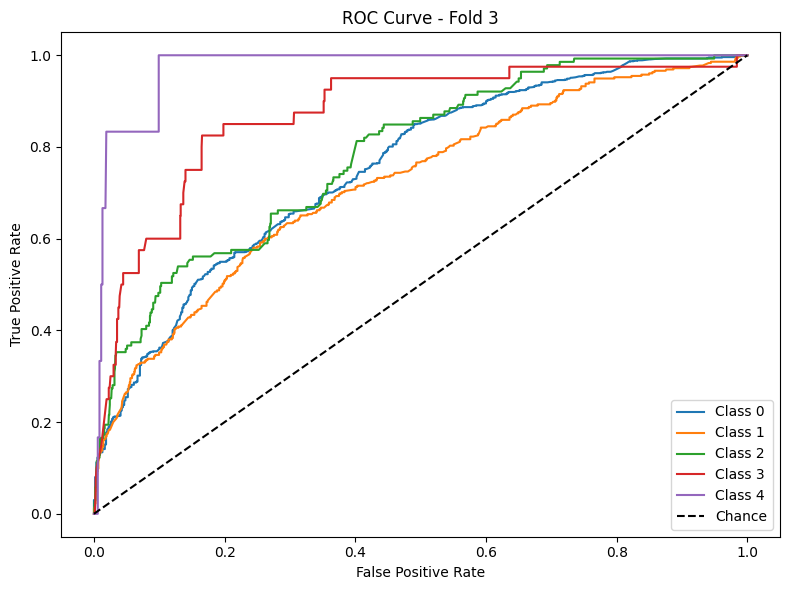

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 9ms/step - accuracy: 0.6119 - loss: 1.0438 - val_accuracy: 0.4980 - val_loss: 1.1018
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.6997 - loss: 0.7949 - val_accuracy: 0.6086 - val_loss: 0.9878
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7196 - loss: 0.7402 - val_accuracy: 0.6034 - val_loss: 0.9738
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7329 - loss: 0.7069 - val_accuracy: 0.6079 - val_loss: 0.9676
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7426 - loss: 0.6887 - val_accuracy: 0.6248 - val_loss: 0.9448
Epoch 6/30
553/553 - 2s - 4ms/step - accuracy: 0.7433 - loss: 0.6725 - val_accuracy: 0.6099 - val_loss: 0.9401
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7480 - loss: 0.6605 - val_accuracy: 0.6138 - val_loss: 0.9122
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7500 - loss: 0.6509 - val_accuracy: 0.6112 - val_loss: 0.9369
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7550 - loss: 0.6400 - val_accuracy: 0.6274 - val_loss: 0.9014
Epoch 10/30


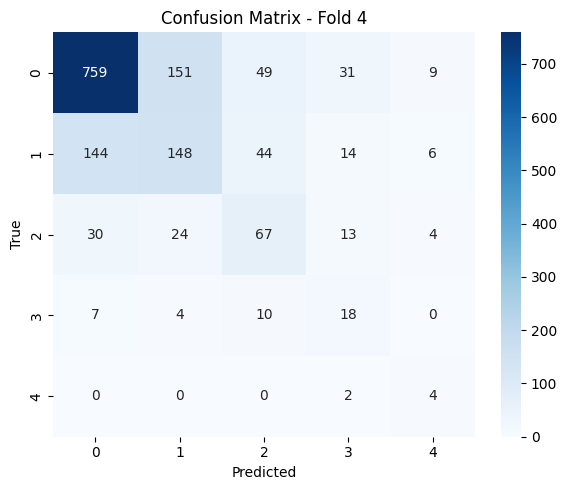

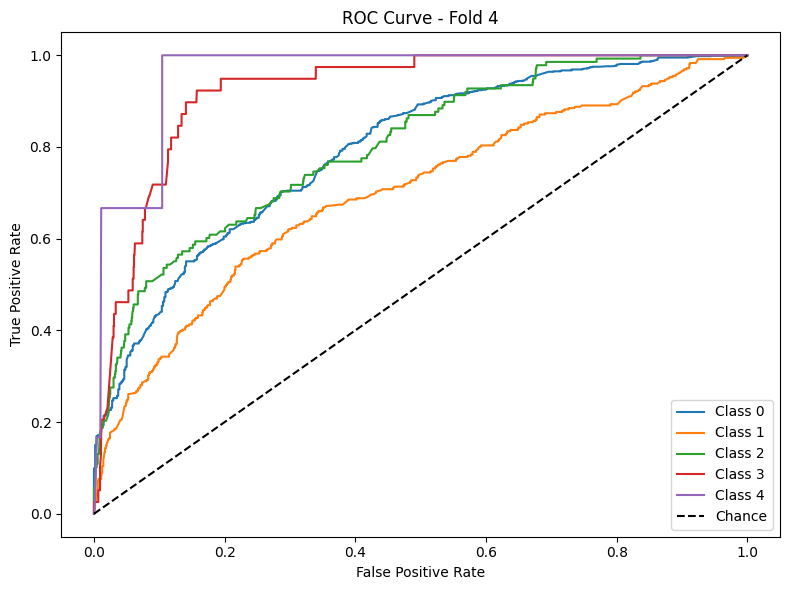

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 9ms/step - accuracy: 0.6126 - loss: 1.0364 - val_accuracy: 0.5176 - val_loss: 1.0898
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.6995 - loss: 0.7876 - val_accuracy: 0.5559 - val_loss: 1.0281
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7136 - loss: 0.7435 - val_accuracy: 0.5793 - val_loss: 0.9868
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7287 - loss: 0.7127 - val_accuracy: 0.5923 - val_loss: 0.9824
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7376 - loss: 0.6906 - val_accuracy: 0.5858 - val_loss: 0.9710
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7402 - loss: 0.6737 - val_accuracy: 0.5988 - val_loss: 0.9653
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7469 - loss: 0.6653 - val_accuracy: 0.6053 - val_loss: 0.9483
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7511 - loss: 0.6574 - val_accuracy: 0.6216 - val_loss: 0.9468
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7559 - loss: 0.6407 - val_accuracy: 0.6092 - val_loss: 0.9558
Epoch 10/30


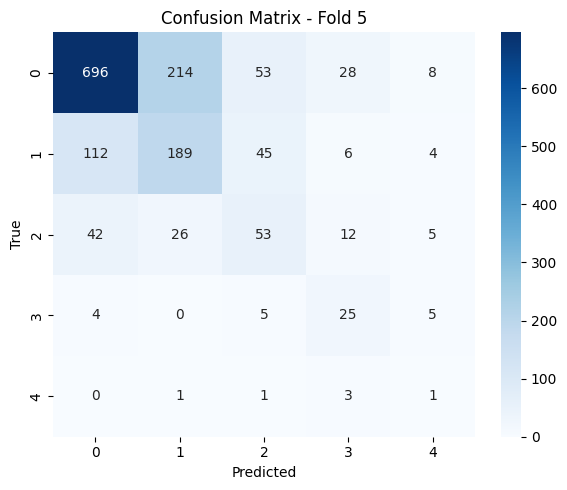

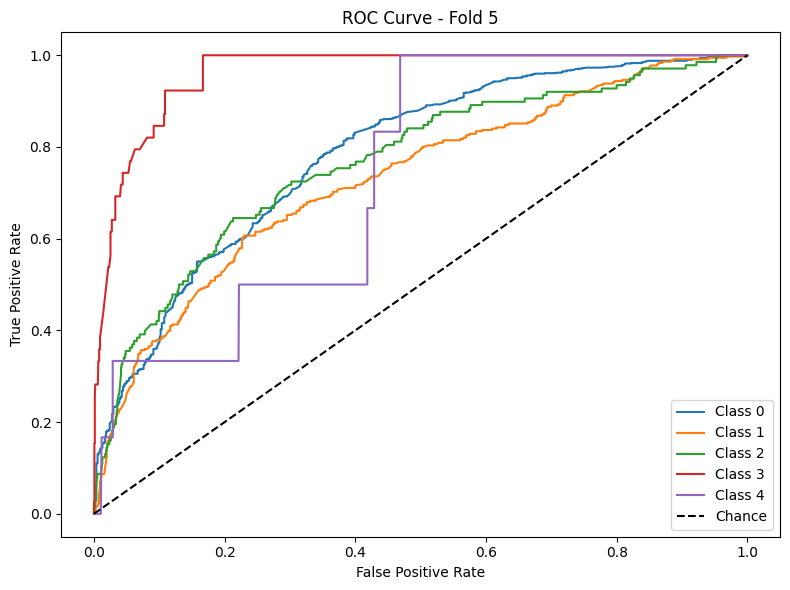


Average Accuracy: 0.6282
Average F1 Macro: 0.4224
Average AUC: 0.8085


In [8]:
# phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
# results = {}

# for i, phase_path in enumerate(phase_paths, start=1):
#     print(f"\n=== Training Phase {i} ===")
#     sample = True
#     model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
#     # Save best model & scaler
#     if sample: 
#         temp = "sample"
#     else: temp = "no_sample"
#     joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
#     joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
#     results[f"phase{i}"] = metrics




phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # Lưu model keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # Lưu scaler sklearn
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       568
           1       0.19      0.33      0.24        63
           2       0.20      0.16      0.18        43
           3       0.08      0.07      0.07        15
           4       0.00      0.00      0.00         9

    accuracy                           0.73       698
   macro avg       0.27      0.28      0.27       698
weighted avg       0.75      0.73      0.74       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


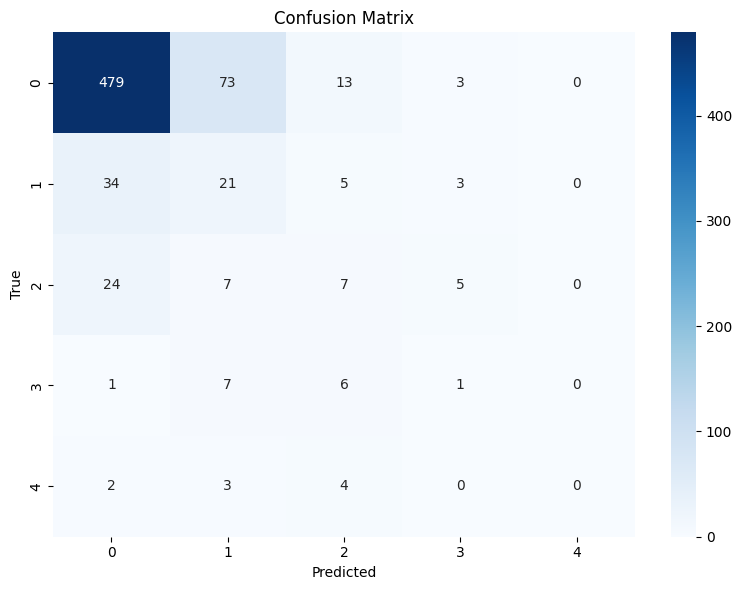


Test AUC (macro-average, OVR): 0.7115


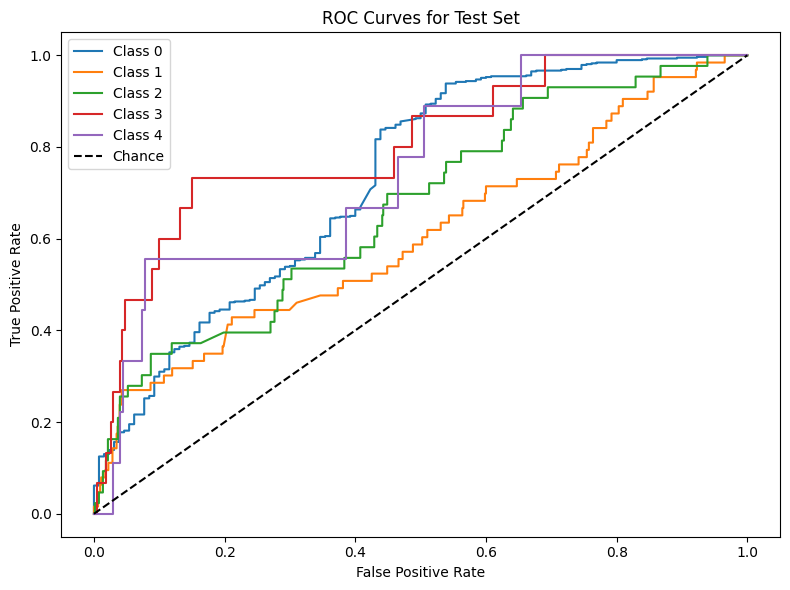

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       544
           1       0.18      0.14      0.15        59
           2       0.28      0.26      0.27        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.80       668
   macro avg       0.27      0.27      0.27       668
weighted avg       0.76      0.80      0.78       668



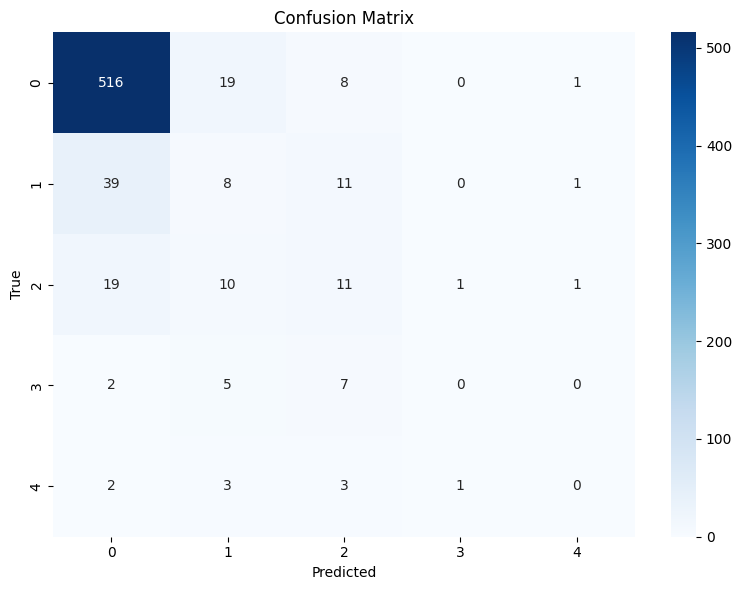


Test AUC (macro-average, OVR): 0.7259


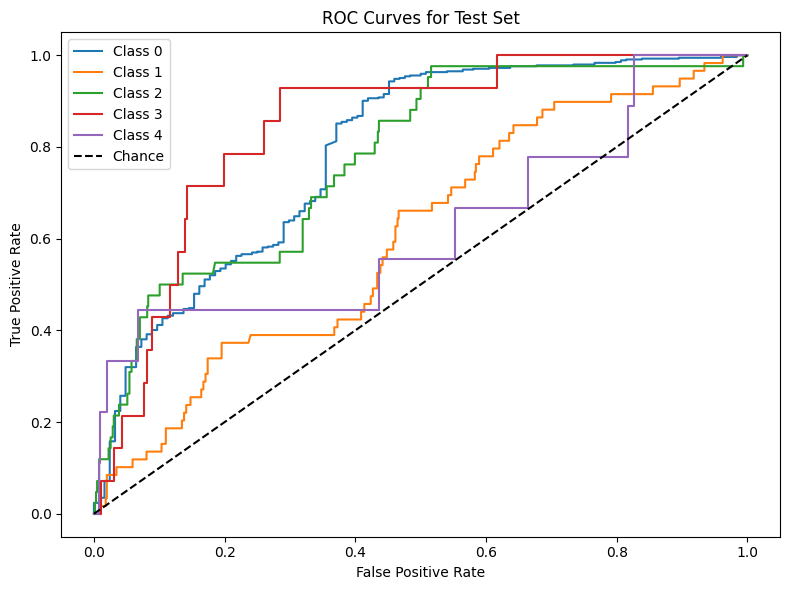

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       455
           1       0.21      0.19      0.20        52
           2       0.21      0.17      0.19        29
           3       0.25      0.50      0.33        10
           4       0.00      0.00      0.00         8

    accuracy                           0.78       554
   macro avg       0.31      0.35      0.32       554
weighted avg       0.77      0.78      0.77       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


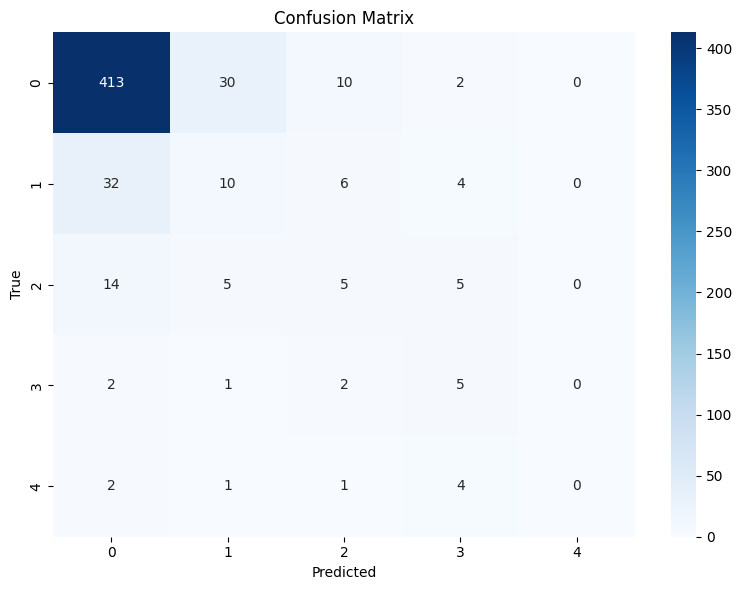


Test AUC (macro-average, OVR): 0.6995


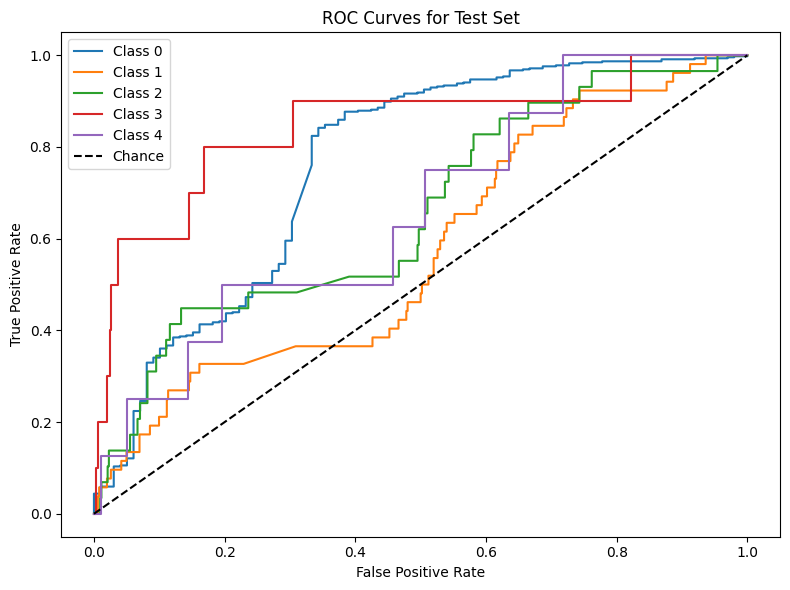

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.56      0.70       395
           1       0.08      0.33      0.12        40
           2       0.18      0.38      0.24        24
           3       0.14      0.10      0.12        10
           4       0.00      0.00      0.00         8

    accuracy                           0.52       477
   macro avg       0.26      0.27      0.24       477
weighted avg       0.77      0.52      0.60       477



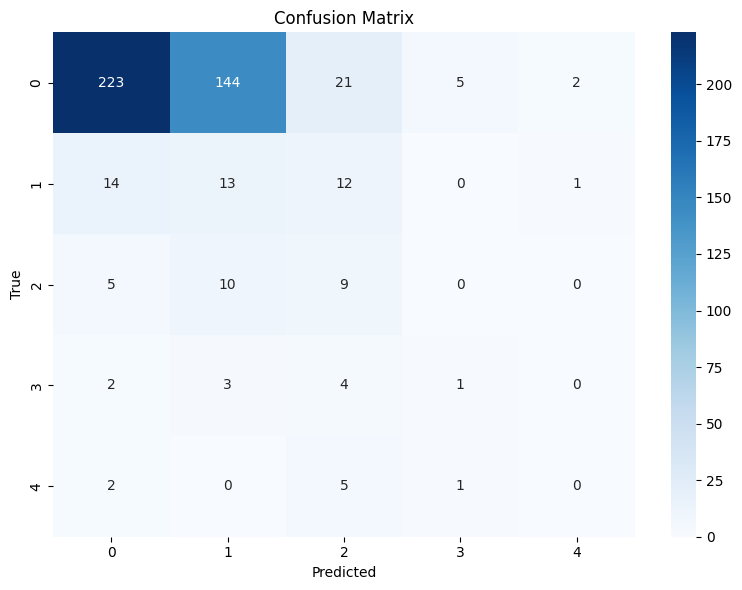


Test AUC (macro-average, OVR): 0.6480


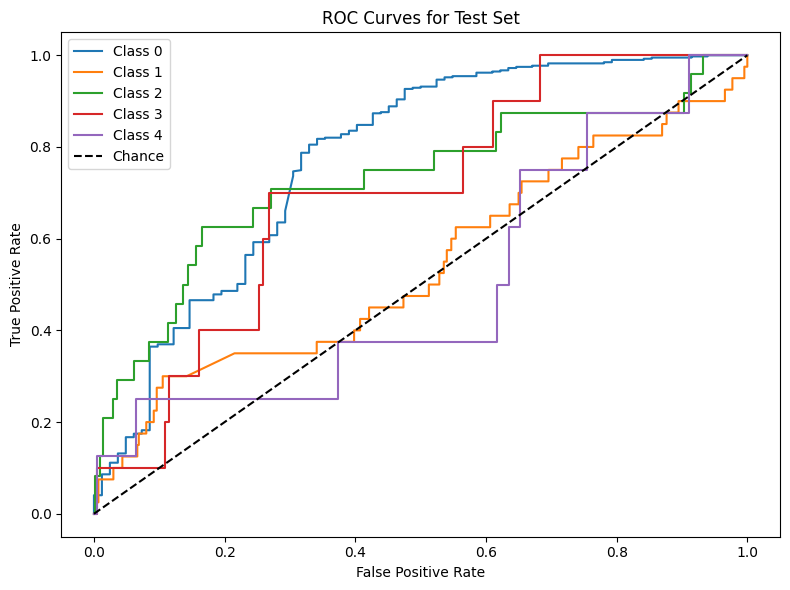

In [9]:
import glob

# for i in range(1, 5):
#     test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
#     # Get model and scaler using glob
#     model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
#     scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
#     # School mapping path
#     school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

#     # Predict on test set
#     predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)



# temp = "sample"  # hoặc "no_sample", tùy cách bạn lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
